# IMPORTS

In [1]:
import os
import math
import time
import torch
import random
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, classification_report
from accelerate import Accelerator, notebook_launcher
from torch.multiprocessing import Manager
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, BertPreTrainedModel, BertConfig, BertForSequenceClassification

# SETUP

In [2]:
warnings.filterwarnings('ignore')

In [3]:
if os.path.exists('/kaggle/working/results') == False:
    os.mkdir('/kaggle/working/results')

if os.path.exists('/kaggle/working/acquired_data') == False:
    os.mkdir('/kaggle/working/acquired_data')

In [4]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=False

set_seed(42)

# GLOBAL VARIABLES

In [5]:
manager = Manager()

# Shared resources
aspect_accuracies = manager.list()
aspect_f1_micros = manager.list()
aspect_f1_macros = manager.list()
sentiment_accuracies = manager.list()
sentiment_f1_micros = manager.list()
sentiment_f1_macros = manager.list()
accuracies = manager.list()
f1_micros = manager.list()
f1_macros = manager.list()

# Non shared resources
epochs = 10
batch_size = 16
sequence_length = 48

aspect_list = ['fuel', 'machine', 'others', 'part', 'price', 'service']
aspect_mapping = {'fuel': 0, 'machine': 1, 'others': 2, 'part': 3, 'price': 4, 'service': 5 }
label_mapping = {"negative": 0, "neutral": 1, 'positive': 2}
ignored_keys = ['labels', 'ori_text', 'ori_label', 'ori_indices', 'aspect']

# LOAD AND PREPROCESS DATA

In [6]:
train_data = pd.read_csv('/kaggle/input/casa-dataset/train_preprocess.csv', encoding='latin-1')
val_data = pd.read_csv('/kaggle/input/casa-dataset/valid_preprocess.csv', encoding='latin-1')
test_data = pd.read_csv('/kaggle/input/casa-dataset/test_preprocess.csv', encoding='latin-1')

data = pd.concat([train_data, val_data, test_data], ignore_index=True)

data.head()

,sentence,fuel,machine,others,part,price,service
0,Saya memakai Honda Jazz GK5 tahun 2014 ( perta...,neutral,neutral,positive,neutral,neutral,neutral
1,Avanza kenapa jadi boros bensin begini dah ah....,negative,neutral,neutral,neutral,neutral,neutral
2,"saran ku dan pengalaman ku , mending beli mobi...",positive,positive,neutral,neutral,neutral,neutral
3,Dari segi harga juga pajero lebih mahal 30 jut...,neutral,neutral,neutral,neutral,positive,neutral
4,Kalo menurut gw enak pajero si,neutral,neutral,positive,neutral,neutral,neutral


In [7]:
data.head()

,sentence,fuel,machine,others,part,price,service
0,Saya memakai Honda Jazz GK5 tahun 2014 ( perta...,neutral,neutral,positive,neutral,neutral,neutral
1,Avanza kenapa jadi boros bensin begini dah ah....,negative,neutral,neutral,neutral,neutral,neutral
2,"saran ku dan pengalaman ku , mending beli mobi...",positive,positive,neutral,neutral,neutral,neutral
3,Dari segi harga juga pajero lebih mahal 30 jut...,neutral,neutral,neutral,neutral,positive,neutral
4,Kalo menurut gw enak pajero si,neutral,neutral,positive,neutral,neutral,neutral


In [8]:
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42, shuffle=False)

In [9]:
train_labels = train_data.columns[1:]
val_labels = val_data.columns[1:]

# Extract features and labels for training and validation
X_train = train_data['sentence'].values
y_train = train_data[train_labels].values
X_val = val_data['sentence'].values
y_val = val_data[val_labels].values

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(864,) (864, 6)
(216,) (216, 6)


# BUILD DATASET & DATALOADERS

In [10]:
class AspectDetectionDataset(Dataset):
    def __init__(self, texts, labels, label_mapping, tokenizer, max_length=sequence_length, use_float=True):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.use_float = use_float
        self.label_mapping = label_mapping

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        
        original_labels = [self.label_mapping[label] for label in self.labels[idx]]
        encoded_labels = [1 if label == 1 else 0 for label in original_labels]
        
        item = {key: val.squeeze() for key, val in encoding.items()}
        item['ori_indices'] = idx
        item['ori_text'] = self.texts[idx]
        item['ori_label'] = torch.tensor(original_labels, dtype=torch.float)
        item['labels'] = torch.tensor(encoded_labels, dtype=torch.float if self.use_float else torch.long)
        
        return item

In [11]:
class SentimentAnalysisDataset(Dataset):
    def __init__(self, texts, labels, aspects, indices, label_mapping, tokenizer, max_length=96, use_float=True):
        self.texts = texts
        self.labels = labels
        self.aspects = aspects
        self.indices = indices
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.use_float = use_float
        self.label_mapping = label_mapping

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = aspect_token + ' ' + self.aspects[idx] + ' ' + review_token + ' ' + self.texts[idx] 
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')

        if isinstance(self.labels[idx], str):
            self.labels[idx] = self.label_mapping[self.labels[idx]]
        elif torch.is_tensor(self.labels[idx]):
            self.labels[idx] = int(self.labels[idx].item())

        encoded_label = 1 if self.labels[idx] == 2 else self.labels[idx]
        one_hot_label = F.one_hot(torch.tensor(encoded_label, dtype=torch.long), num_classes=2).float()

        item = {key: val.squeeze() for key, val in encoding.items()}
        item['aspect'] = self.aspects[idx]
        item['labels'] = one_hot_label
        item['ori_indices'] = self.indices[idx]
        item['ori_text'] = self.texts[idx]
        item['ori_label'] = torch.tensor(self.labels[idx], dtype=torch.long)

        return item

In [12]:
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')
review_token = '[REVIEW]'
aspect_token = '[ASPECT]'
special_tokens_dict = {'additional_special_tokens': [review_token, aspect_token]}
num_added_tokens = tokenizer.add_special_tokens(special_tokens_dict)

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

In [13]:
def build_aspect_dataset(X_train, y_train, X_val, y_val, sequence_length, num_workers=4):
    train_dataset = AspectDetectionDataset(X_train, y_train, label_mapping, tokenizer, max_length=sequence_length)
    val_dataset = AspectDetectionDataset(X_val, y_val, label_mapping, tokenizer, max_length=sequence_length)
    
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers,
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers, 
    )

    return train_loader, val_loader, train_dataset, val_dataset

In [14]:
def build_sentiment_dataset(device, train_dataset, val_dataset, aspect_detection_model, tokenizer, max_length=sequence_length):
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4, 
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4, 
    )

    aspect_detection_model.to(device)
    aspect_detection_model.eval()

    train_data = []
    train_labels = []
    train_aspects = []
    train_indices = []

    val_data = []
    val_labels = []
    val_aspects = []
    val_indices = []

    # Transform train set
    start_time = time.time()
    with torch.no_grad():
        for batch in train_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            labels = batch['labels'].to(device)
            
            outputs = aspect_detection_model(**inputs)
            preds = torch.sigmoid(outputs.logits).round()

            for i in range(len(preds)):
                for j in range(len(preds[i])):
                    if int(preds[i][j]) != 1:
                        train_aspects.append(aspect_list[j])
                        train_data.append(batch['ori_text'][i])
                        train_labels.append(batch['ori_label'][i][j])
                        train_indices.append(batch['ori_indices'][i])
            
        # Transform validation set
        for batch in val_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            labels = batch['labels'].to(device)
            
            outputs = aspect_detection_model(**inputs)
            preds = torch.sigmoid(outputs.logits).round()

            for i in range(len(preds)):
                for j in range(len(preds[i])):
                    if int(preds[i][j]) != 1:
                        val_aspects.append(aspect_list[j])
                        val_data.append(batch['ori_text'][i])
                        val_labels.append(batch['ori_label'][i][j])
                        val_indices.append(batch['ori_indices'][i])

    train_dataset = SentimentAnalysisDataset(train_data, train_labels, train_aspects, train_indices, label_mapping, tokenizer, max_length=max_length)
    val_dataset = SentimentAnalysisDataset(val_data, val_labels, val_aspects, val_indices, label_mapping, tokenizer, max_length=max_length)

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=4, 
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4, 
    )

    return train_loader, val_loader, train_dataset, val_dataset

# TRAIN THE MODEL

In [15]:
total_data = len(X_train) + len(X_val)
initial_train_size = int(0.05 * total_data)
checkpoints = [
    int(0.5 * total_data), 
    int(0.6 * total_data), 
    int(0.7 * total_data),
    len(X_train)
]
min_increment = 25

In [16]:
def compute_metrics(p, label, classes):
    preds = torch.tensor(p.predictions) # Sigmoid and threshold for multi-label
    labels = torch.tensor(p.label_ids)

    # Hamming accuracy: proportion of correctly predicted labels over total labels
    hamming_accuracy = (preds == labels).float().mean().item()

    # Standard multi-label precision, recall, and F1 metrics
    precision, recall, f1_micro, _ = precision_recall_fscore_support(labels, preds, average='micro', zero_division=0)
    _, _, f1_macro, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)

    report = classification_report(
        labels, 
        preds, 
        labels=label,
        target_names=classes,
        zero_division=0
    ) 

    return {
        'accuracy': hamming_accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'report': report
    }

In [17]:
def compute_metrics_overall(p, classes):
    preds = torch.tensor(p.predictions)
    labels = torch.tensor(p.label_ids)

    # Ensure it's in the correct shape
    if preds.shape != labels.shape:
        raise ValueError("Shape mismatch: predictions and labels must have the same shape.")

    # Hamming accuracy: proportion of correctly predicted labels over total labels
    hamming_accuracy = (preds == labels).float().mean().item()

    # Compute per-label (column-wise) precision, recall, F1
    precision_list, recall_list, f1_micro_list, f1_macro_list = [], [], [], []
    
    for i in range(labels.shape[1]):  # Loop through each column (multi-output)
        prec, rec, f1_micro, _ = precision_recall_fscore_support(
            labels[:, i], preds[:, i], average='micro', zero_division=0
        )
        _, _, f1_macro, _ = precision_recall_fscore_support(
            labels[:, i], preds[:, i], average='macro', zero_division=0
        )

        precision_list.append(prec)
        recall_list.append(rec)
        f1_micro_list.append(f1_micro)
        f1_macro_list.append(f1_macro)

    # Compute average metrics across all outputs
    precision = sum(precision_list) / len(precision_list)
    recall = sum(recall_list) / len(recall_list)
    f1_micro = sum(f1_micro_list) / len(f1_micro_list)
    f1_macro = sum(f1_macro_list) / len(f1_macro_list)

    # Generate classification report per output
    reports = [classification_report(labels[:, i], preds[:, i], target_names=classes, zero_division=0) for i in range(labels.shape[1])]

    return {
        'accuracy': hamming_accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'reports': reports  # Returns list of reports, one for each output label
    }


In [18]:
def train_model(current_train_size, train_indices, aspect_metrics, sentiment_metrics, metrics, trials, seed, filename):
    accelerator = Accelerator(mixed_precision='fp16')  # Initialize the accelerator
    device = accelerator.device

    aspect_model = BertForSequenceClassification.from_pretrained(
        'indobenchmark/indobert-base-p1',
        num_labels=len(train_labels),
        problem_type="multi_label_classification"
    )

    # Freeze the first few layers of the encoder
    for name, param in aspect_model.named_parameters():
        if "encoder.layer" in name:
            layer_num = name.split(".")[3]
            try:
                if int(layer_num) < 6:
                    param.requires_grad = False
            except ValueError:
                continue

    # Define optimizer and loss function
    aspect_optimizer = torch.optim.AdamW(aspect_model.parameters(), lr=2e-5, weight_decay=0.01)
    loss_fn = torch.nn.BCEWithLogitsLoss()

    # Define DataLoaders
    current_X_train = [X_train[i] for i in train_indices]
    current_y_train = [y_train[i] for i in train_indices]
    aspect_train_loader, aspect_val_loader, aspect_train_dataset, aspect_val_dataset = build_aspect_dataset(current_X_train, current_y_train, X_val, y_val, sequence_length)

    # Prepare everything with Accelerator
    aspect_model, aspect_optimizer, aspect_train_loader, aspect_val_loader = accelerator.prepare(
        aspect_model, aspect_optimizer, aspect_train_loader, aspect_val_loader
    )

    nearest_cp = current_train_size
    if nearest_cp not in checkpoints:
        for cp in checkpoints:
            if cp > current_train_size:
                nearest_cp = cp
                break
    percentage = math.ceil(nearest_cp / total_data * 100)

    aspect_result = None
    start_time = time.time()

    # ASPECT DETECTION
    accelerator.print("ASPECT DETECTION")
    for epoch in range(epochs):
        aspect_model.train()
        epoch_loss = 0

        for batch in aspect_train_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            labels = batch['labels']
        
            aspect_optimizer.zero_grad()
            outputs = aspect_model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            accelerator.backward(loss)
            aspect_optimizer.step()
        
            epoch_loss += loss.item()
            
        aspect_model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in aspect_val_loader:
                inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
                labels = batch['labels']
                
                outputs = aspect_model(**inputs)
                preds = torch.sigmoid(outputs.logits).round()

                # Gather predictions and labels from all devices
                all_preds.append(accelerator.gather(preds))
                all_labels.append(accelerator.gather(labels))

        all_preds = torch.cat(all_preds).cpu().numpy()
        all_labels = torch.cat(all_labels).cpu().numpy()

        result = compute_metrics(
            type('EvalOutput', (object,), {'predictions': all_preds, 'label_ids': all_labels}),
            None,
            ['fuel', 'machine', 'others', 'part', 'price', 'service']
        )

        if aspect_result is None or result['f1_micro'] >= aspect_result['f1_micro']:
            accelerator.print("Higher F1 achieved, saving model")
            
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(aspect_model)
            unwrapped_model.save_pretrained(
                f'{filename}-aspect-{trials + 1}-model-{percentage}',
                is_main_process=accelerator.is_main_process,
                save_function=accelerator.save,
            )
            aspect_result = result

        accelerator.print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {round(epoch_loss / len(aspect_train_loader), 4)}, Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")

    accelerator.print(f"\nAspect detection accuracy: {round(aspect_result['accuracy'], 4)}, F1 Micro: {round(aspect_result['f1_micro'], 4)}, F1 Macro: {round(aspect_result['f1_macro'], 4)}")
    accelerator.print(aspect_result['report'])

    best_aspect_model = BertForSequenceClassification.from_pretrained(f'{filename}-aspect-{trials + 1}-model-{percentage}')
    best_aspect_model = accelerator.prepare(best_aspect_model)

    # SENTIMENT ANALYSIS ON NON NEUTRAL ASPECTS
    accelerator.print("--------------------------------------------------")
    accelerator.print("SENTIMENT ANALYSIS")

    sentiment_model = BertForSequenceClassification.from_pretrained(
        'indobenchmark/indobert-base-p1',
        num_labels=2,
    )
    sentiment_optimizer = torch.optim.AdamW(sentiment_model.parameters(), lr=2e-5, weight_decay=0.01)

    for name, param in sentiment_model.named_parameters():
        if "encoder.layer" in name:
            layer_num = name.split(".")[3]
            try:
                if int(layer_num) < 6:
                    param.requires_grad = False
            except ValueError:
                continue

    accelerator.wait_for_everyone()
    sentiment_train_loader, sentiment_val_loader, sentiment_train_dataset, sentiment_val_dataset = build_sentiment_dataset(
        device, aspect_train_dataset, aspect_val_dataset, best_aspect_model, tokenizer, max_length=sequence_length
    )
    sentiment_model, sentiment_optimizer, sentiment_train_loader, sentiment_val_loader = accelerator.prepare(
        sentiment_model, sentiment_optimizer, sentiment_train_loader, sentiment_val_loader
    )
    sentiment_result = None

    for epoch in range(epochs):
        sentiment_model.train()
        epoch_loss = 0
        
        for batch in sentiment_train_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            labels = batch['labels']
        
            sentiment_optimizer.zero_grad()
            outputs = sentiment_model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            accelerator.backward(loss)
            sentiment_optimizer.step()
        
            epoch_loss += loss.item()

        sentiment_model.eval()
        sentiment_val_outputs = []
        
        with torch.no_grad():
            for batch in sentiment_val_loader:
                inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
                
                outputs = sentiment_model(**inputs)
                preds = torch.sigmoid(outputs.logits).round()

                for i in range(len(preds)):
                    val_output = {
                        'label': batch['labels'][i],
                        'aspect': batch['aspect'][i],
                        'ori_indices': batch['ori_indices'][i],
                        'pred': np.argmax(preds[i].cpu().numpy()),
                    }
                    sentiment_val_outputs.append(val_output)

        sentiment_val_outputs = accelerator.gather_for_metrics(sentiment_val_outputs)
        unique_val_outputs = {(x['ori_indices'].item(), x['aspect']): x for x in sentiment_val_outputs}
        sentiment_val_outputs = list(unique_val_outputs.values())

        result = compute_metrics(
            type('EvalOutput', (object,), {'predictions': [item['pred'] for item in sentiment_val_outputs], 'label_ids': [np.argmax(item['label'].cpu().numpy()) for item in sentiment_val_outputs]}),
            [0, 1],
            ['negative', 'positive']
        )

        if sentiment_result is None or result['f1_micro'] >= sentiment_result['f1_micro']:
            accelerator.print("Higher F1 achieved, saving model")
            sentiment_result = result
            
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(sentiment_model)
            unwrapped_model.save_pretrained(
                 f'{filename}-sentiment-{trials + 1}-model-{percentage}',
                is_main_process=accelerator.is_main_process,
                save_function=accelerator.save,
            )

        accelerator.print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {round(epoch_loss / len(sentiment_train_loader), 4)}, Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")
    
    end_time = time.time()
    duration = end_time - start_time

    accelerator.print(f"\nSentiment analysis accuracy: {round(sentiment_result['accuracy'], 4)}, F1 Micro: {round(sentiment_result['f1_micro'], 4)}, F1 Macro: {round(sentiment_result['f1_macro'], 4)}")
    accelerator.print(sentiment_result['report'])

    accelerator.wait_for_everyone()
    best_sentiment_model = BertForSequenceClassification.from_pretrained( f'{filename}-sentiment-{trials + 1}-model-{percentage}')
    best_sentiment_model = accelerator.prepare(best_sentiment_model)

    # Compute overall metrics
    aspect_labels = []
    aspect_indices = []
    aspect_preds = []

    aspect_outputs = {}
    sentiment_outputs = []
    
    best_aspect_model.eval()
    best_sentiment_model.eval()

    with torch.no_grad():
        for batch in aspect_val_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            outputs = best_aspect_model(**inputs)
            preds = torch.sigmoid(outputs.logits).round()

            aspect_indices.append(accelerator.gather(batch['ori_indices']))
            aspect_labels.append(accelerator.gather(batch['ori_label']))
            aspect_preds.append(accelerator.gather(preds))

        aspect_indices = torch.cat(aspect_indices).cpu().numpy()
        aspect_labels = torch.cat(aspect_labels).cpu().numpy()
        aspect_preds = torch.cat(aspect_preds).cpu().numpy()

        accelerator.wait_for_everyone()
        aspect_outputs = [
            {'ori_indices': aspect_indices[i], 
             'ori_labels': aspect_labels[i], 
             'pred': aspect_preds[i]}
            for i in range(len(aspect_preds))
        ]
        aspect_outputs = {x['ori_indices'].item(): x for x in aspect_outputs}
    
        for batch in sentiment_val_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            outputs = best_sentiment_model(**inputs)
            preds = torch.sigmoid(outputs.logits).round()
    
            for i in range(len(preds)):
                output = {
                    'aspect': batch['aspect'][i],
                    'ori_indices': batch['ori_indices'][i],
                    'pred': np.argmax(preds[i].cpu().numpy()),
                }
                sentiment_outputs.append(output)

        sentiment_outputs = accelerator.gather_for_metrics(sentiment_outputs)
        sentiment_outputs = {(x['ori_indices'].item(), x['aspect']): x for x in sentiment_outputs}

    # Replcae non neutral aspect to its predicted sentiment
    accelerator.wait_for_everyone()
    if accelerator.is_main_process:
        i = -1
        for (ori_index, aspect), value in sentiment_outputs.items():
            aspect = aspect_mapping[aspect]
            aspect_outputs[ori_index]['pred'][aspect] = 2 if value['pred'] == 1.0 else value['pred']

        result = compute_metrics_overall(
            type('EvalOutput', (object,), {'predictions': [output['pred'] for output in aspect_outputs.values()], 'label_ids': [output['ori_labels'] for output in aspect_outputs.values()]}),
            ['negative', 'neutral', 'positive'],
        )

        accelerator.print("--------------------------------------------------")
        accelerator.print(f"Iteration {current_train_size}: Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")
        accelerator.print("--------------------------------------------------")
        for i in range(len(train_labels)):
            accelerator.print(f"Aspect {aspect_list[i]} report:")
            accelerator.print(result['reports'][i])
       
        
        aspect_metrics[0].append(aspect_result['accuracy'])
        aspect_metrics[1].append(aspect_result['f1_micro'])
        aspect_metrics[2].append(aspect_result['f1_macro'])
        sentiment_metrics[0].append(sentiment_result['accuracy'])
        sentiment_metrics[1].append(sentiment_result['f1_micro'])
        sentiment_metrics[2].append(sentiment_result['f1_macro'])
        metrics[0].append(current_train_size)
        metrics[1].append(result['accuracy'])
        metrics[2].append(result['f1_micro'])
        metrics[3].append(result['f1_macro'])
        
    accelerator.print(f"Total train time: {duration} s")
    accelerator.end_training()
    return

# PLOT THE RESULTS

In [19]:
def plot_result(data_used, accuracies, f1_micros, f1_macros):
    fig, axs = plt.subplots(1, 3, figsize=(21, 5))
    data_used = [round(data / total_data * 100, 1) for data in data_used]

    # Plot for Accuracy
    axs[0].plot(data_used, accuracies, label="Accuracy", color="blue")
    axs[0].set_xlabel("Percentage of data used")
    axs[0].set_title("Accuracy")
    axs[0].set_xticks(data_used)

    # Plot for F1 Micro
    axs[1].plot(data_used, f1_micros, label="F1 Micro", color="orange")
    axs[1].set_xlabel("Percentage of data used")
    axs[1].set_title("F1 Micro")
    axs[1].set_xticks(data_used)

    # Plot for F1 Macro
    axs[2].plot(data_used, f1_macros, label="F1 Macro", color="green")
    axs[2].set_xlabel("Percentage of data used")
    axs[2].set_title("F1 Macro")
    axs[2].set_xticks(data_used)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

# QUERY STRATEGY

In [20]:
def least_confidence_sampling(aspect_model, sentiment_model, X_pool, train_indices, remaining_indices, sampling_dur, new_samples, trials, filename, n_samples=min_increment):
    accelerator = Accelerator(mixed_precision="fp16")
    device = accelerator.device

    aspect_model.to(device)
    aspect_model.eval()
    sentiment_model.to(device)
    sentiment_model.eval()

    current_train_size = len(train_indices)
    aspect_dataset = AspectDetectionDataset(
        X_pool, 
        [['neutral' for i in range(len(train_labels))] for x in range(len(X_pool))], 
        label_mapping, 
        tokenizer, 
        max_length=sequence_length
    )
    aspect_loader = DataLoader(
        aspect_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=4,
        pin_memory=True,
    )
    
    aspect_outputs = {}
    sentiment_outputs = {}

    aspects = []
    data = []
    labels = []
    indices = []

    start_time = time.time()

    # Pass through aspect detction model
    for batch in aspect_loader:
        token_type_ids = batch['token_type_ids'].to(device, non_blocking=True)
        input_ids = batch['input_ids'].to(device, non_blocking=True)
        attention_mask = batch['attention_mask'].to(device, non_blocking=True)
        
        with torch.no_grad():
            outputs = aspect_model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
            preds = torch.sigmoid(outputs.logits)

        for i in range(len(preds)):
            aspect_outputs[batch['ori_indices'][i].item()] = np.max(preds[i].cpu().numpy())
            
            for j in range(len(preds[i])):
                if int(preds[i][j].round()) != 1:
                    aspects.append(aspect_list[j])
                    data.append(batch['ori_text'][i])
                    labels.append(batch['ori_label'][i][j])
                    indices.append(batch['ori_indices'][i])
    
    sentiment_dataset = SentimentAnalysisDataset(data, labels, aspects, indices, label_mapping, tokenizer, max_length=sequence_length)
    sentiment_loader = torch.utils.data.DataLoader(
        sentiment_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4,
    )

    # Pass through sentiment analysis model
    for batch in sentiment_loader:
        token_type_ids = batch['token_type_ids'].to(device, non_blocking=True)
        input_ids = batch['input_ids'].to(device, non_blocking=True)
        attention_mask = batch['attention_mask'].to(device, non_blocking=True)

        with torch.no_grad():
            outputs = sentiment_model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
            preds = torch.sigmoid(outputs.logits)

        for i in range(len(preds)):
            ori_index = batch['ori_indices'][i].item()
            if ori_index in sentiment_outputs.keys():
                max_pred = np.max(preds[i].cpu().numpy())
                sentiment_outputs[ori_index] = max_pred if max_pred > sentiment_outputs[ori_index] else sentiment_outputs[ori_index]
            else:
                sentiment_outputs[ori_index] = np.max(preds[i].cpu().numpy())

    accelerator.wait_for_everyone()
    if accelerator.is_main_process:
        aspect_outputs = dict(sorted(aspect_outputs.items()))
    
        # accelerator.print(aspect_outputs)
        for key, val in sentiment_outputs.items():
            aspect_outputs[key] = 1 - ((val + aspect_outputs[key]) / 2)
    
        # accelerator.print(aspect_outputs)
        uncertainties = np.array(list(aspect_outputs.values()))
        sorted_unc = np.argsort(uncertainties)
        sorted_unc = sorted_unc[::-1]

        threshold = np.percentile(uncertainties, 90)
        items_greater_than_average = uncertainties[uncertainties >= threshold]
        num_of_candidates = len(items_greater_than_average)
        
        # Check nearest checkpoint
        nearest_cp = 0
        for cp in checkpoints:
            if cp > current_train_size:
                nearest_cp = cp
                break
        
        if num_of_candidates <= n_samples and n_samples < nearest_cp - current_train_size:
            least_confident_indices = sorted_unc[:n_samples]
        elif num_of_candidates > n_samples and num_of_candidates < nearest_cp - current_train_size:
            least_confident_indices = sorted_unc[:max(n_samples, min(math.ceil(0.1*len(sorted_unc)), num_of_candidates))]
        else:
            least_confident_indices = sorted_unc[:nearest_cp - current_train_size]
    
            temp = train_indices.copy()
            temp.extend([remaining_indices[i] for i in least_confident_indices])
            
            # Save acquired data up to checkpoint
            acquired_data = pd.DataFrame({
                'processed_text': [X_train[i] for i in temp],
                'fuel': [y_train[i][0] for i in temp],
                'machine': [y_train[i][1] for i in temp],
                'others': [y_train[i][2] for i in temp],
                'part': [y_train[i][3] for i in temp],
                'price': [y_train[i][4] for i in temp],
                'service': [y_train[i][5] for i in temp],
            })
    
            acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)
    
        end_time = time.time() 
        duration = end_time - start_time
    
        sampling_dur.append(duration)
        for i in least_confident_indices:
            new_samples.append(remaining_indices[i])
            
        print("Nearest checkpoint:", nearest_cp)
        print("Threshold:", threshold)
        print("Samples above threshold:", num_of_candidates)
        print("Acquired samples:", len(least_confident_indices))
        print(f"Sampling duration: {duration} seconds")

# MAIN LOOP

In [21]:
def active_learning(seed, i, init_size):
    aspect_accuracies = manager.list()
    aspect_f1_micros = manager.list()
    aspect_f1_macros = manager.list()
    sentiment_accuracies = manager.list()
    sentiment_f1_micros = manager.list()
    sentiment_f1_macros = manager.list()
    accuracies = manager.list()
    f1_micros = manager.list()
    f1_macros = manager.list()
    data_used = manager.list()
    sampling_dur = manager.list()
    new_samples = manager.list()
    filename = f'casa-lc-init-{init_size}'

    set_seed(seed)
    
    print("===============================================")
    print("Init Size {}".format(init_size))
    print("Random seed:", seed)
    
    train_indices = np.random.choice(range(len(X_train)), initial_train_size, replace=False).tolist()
    remaining_indices = list(set(range(len(X_train))) - set(train_indices))
    
    current_train_size = initial_train_size
    
    start_time = time.time()
    while current_train_size < checkpoints[len(checkpoints) - 1]:
        # Train the model
        args = (
            current_train_size, 
            train_indices, 
            (aspect_accuracies, aspect_f1_micros, aspect_f1_macros), 
            (sentiment_accuracies, sentiment_f1_micros, sentiment_f1_macros),
            (data_used, accuracies, f1_micros, f1_macros), 
            i,
            seed,
            filename
        )
        notebook_launcher(train_model, args, num_processes=2)

        nearest_cp = current_train_size
        if nearest_cp not in checkpoints:
            for cp in checkpoints:
                if cp > current_train_size:
                    nearest_cp = cp
                    break
        percentage = math.ceil(nearest_cp / total_data * 100)

        aspect_model = BertForSequenceClassification.from_pretrained(f'{filename}-aspect-{i+1}-model-{percentage}')
        sentiment_model = BertForSequenceClassification.from_pretrained(f'{filename}-sentiment-{i+1}-model-{percentage}')
    
        # Perform query strategy to select new samples
        new_samples = manager.list()
        sampling_args = (
            aspect_model, 
            sentiment_model, 
            [X_train[i] for i in remaining_indices], 
            train_indices, 
            remaining_indices, 
            sampling_dur, 
            new_samples, 
            i,
            filename
        )
        notebook_launcher(least_confidence_sampling, sampling_args, num_processes=2)
        new_samples = list(new_samples)
        train_indices.extend(new_samples)
        remaining_indices = list(set(remaining_indices) - set(new_samples))
    
        # Update current training size
        current_train_size = len(train_indices)
        print("New train size: {}".format(current_train_size))
    
    # Train last epoch
    args = (
        current_train_size, 
        train_indices, 
        (aspect_accuracies, aspect_f1_micros, aspect_f1_macros), 
        (sentiment_accuracies, sentiment_f1_micros, sentiment_f1_macros),
        (data_used, accuracies, f1_micros, f1_macros), 
        i,
        seed,
        filename
    )
    notebook_launcher(train_model, args, num_processes=2)
    data_used, accuracies, f1_micros, f1_macros, sampling_dur = list(data_used), list(accuracies), list(f1_micros), list(f1_macros), list(sampling_dur)
    
    end_time = time.time()
    duration = end_time - start_time
    
    # print(f"Total sampling time: {np.array(sampling_dur).sum().round(2)} seconds")
    print(f"Total runtime: {duration} seconds")
    
    plot_result(data_used, accuracies, f1_micros, f1_macros)
    
    results = pd.DataFrame({
        'Data Used': data_used,
        'Aspect Accuracy': aspect_accuracies,
        'Aspect F1 Micro': aspect_f1_micros,
        'Aspect F1 Macro': aspect_f1_macros,
        'Sentiment Accuracy': sentiment_accuracies,
        'Sentiment F1 Micro': sentiment_f1_micros,
        'Sentiment F1 Macro': sentiment_f1_macros,
        'Accuracy': accuracies,
        'F1 Micro': f1_micros,
        'F1 Macro': f1_macros,
    })
    
    sampling_dur.insert(0, 0)
    results['Sampling Duration'] = sampling_dur
    results.to_csv(f'results/{filename}-{i+1}-results.csv', index=False)

Init Size 1
Random seed: 81
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6716, Accuracy: 0.6763, F1 Micro: 0.7845, F1 Macro: 0.6875
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.623, Accuracy: 0.724, F1 Micro: 0.8277, F1 Macro: 0.7588
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.5676, Accuracy: 0.7478, F1 Micro: 0.8485, F1 Macro: 0.8168
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.5258, Accuracy: 0.776, F1 Micro: 0.8712, F1 Macro: 0.865
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4874, Accuracy: 0.7932, F1 Micro: 0.884, F1 Macro: 0.8824
Epoch 6/10, Train Loss: 0.453, Accuracy: 0.7902, F1 Micro: 0.8826, F1 Macro: 0.8811
Epoch 7/10, Train Loss: 0.4214, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Epoch 8/10, Train Loss: 0.4196, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Epoch 9/10, Train Loss: 0.3868, Accuracy: 0.7909, F1 Micro: 0.8831, F1 Macro: 0.8816
Epoch 10/10, Train Loss: 0.3569, Accuracy: 0.7917, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6232, Accuracy: 0.7778, F1 Micro: 0.7778, F1 Macro: 0.4375
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4977, Accuracy: 0.8889, F1 Micro: 0.8889, F1 Macro: 0.4706
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3777, Accuracy: 0.8889, F1 Micro: 0.8889, F1 Macro: 0.4706
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2928, Accuracy: 0.8889, F1 Micro: 0.8889, F1 Macro: 0.4706
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2176, Accuracy: 0.8889, F1 Micro: 0.8889, F1 Macro: 0.4706
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1723, Accuracy: 0.8889, F1 Micro: 0.8889, F1 Macro: 0.4706
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1318, Accuracy: 0.8889, F1 Micro: 0.8889, F1 Macro: 0.4706
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1066, Accuracy: 0.8889, F1 Micro: 0.8889, F1 Macro: 0.4706
Higher F1 achieved, saving model
Epoch 9/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6205, Accuracy: 0.7284, F1 Micro: 0.8331, F1 Macro: 0.7711
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5277, Accuracy: 0.7909, F1 Micro: 0.8824, F1 Macro: 0.8805
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4823, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Epoch 4/10, Train Loss: 0.472, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Epoch 5/10, Train Loss: 0.4516, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.4142, Accuracy: 0.7954, F1 Micro: 0.8853, F1 Macro: 0.8838
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3894, Accuracy: 0.7976, F1 Micro: 0.8863, F1 Macro: 0.8848
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3644, Accuracy: 0.8065, F1 Micro: 0.8902, F1 Macro: 0.8885
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.3233, Accuracy: 0.8237, F1 Micro: 0.8985, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5641, Accuracy: 0.6569, F1 Micro: 0.6569, F1 Macro: 0.3964
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4635, Accuracy: 0.6569, F1 Micro: 0.6569, F1 Macro: 0.3964
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4476, Accuracy: 0.6569, F1 Micro: 0.6569, F1 Macro: 0.3964
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4069, Accuracy: 0.6569, F1 Micro: 0.6569, F1 Macro: 0.3964
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4929, Accuracy: 0.6569, F1 Micro: 0.6569, F1 Macro: 0.3964
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3473, Accuracy: 0.6569, F1 Micro: 0.6569, F1 Macro: 0.3964
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2881, Accuracy: 0.6667, F1 Micro: 0.6667, F1 Macro: 0.4266
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3507, Accuracy: 0.6667, F1 Micro: 0.6667, F1 Macro: 0.4266
Higher F1 achieved, saving model
Epoch 9/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5937, Accuracy: 0.7932, F1 Micro: 0.8841, F1 Macro: 0.8825
Epoch 2/10, Train Loss: 0.4983, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Epoch 3/10, Train Loss: 0.4787, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4249, Accuracy: 0.7932, F1 Micro: 0.8841, F1 Macro: 0.8825
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4116, Accuracy: 0.8333, F1 Micro: 0.904, F1 Macro: 0.9025
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3349, Accuracy: 0.8847, F1 Micro: 0.9306, F1 Macro: 0.9289
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.301, Accuracy: 0.8981, F1 Micro: 0.9377, F1 Macro: 0.9361
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2597, Accuracy: 0.9033, F1 Micro: 0.9405, F1 Macro: 0.939
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2215, Accuracy: 0.9107, F1 Micro: 0.9452, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5657, Accuracy: 0.6981, F1 Micro: 0.6981, F1 Macro: 0.4111
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.56, Accuracy: 0.6981, F1 Micro: 0.6981, F1 Macro: 0.4111
Epoch 3/10, Train Loss: 0.5199, Accuracy: 0.6887, F1 Micro: 0.6887, F1 Macro: 0.4078
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4375, Accuracy: 0.7925, F1 Micro: 0.7925, F1 Macro: 0.7038
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3013, Accuracy: 0.8726, F1 Micro: 0.8726, F1 Macro: 0.8576
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1804, Accuracy: 0.8821, F1 Micro: 0.8821, F1 Macro: 0.8698
Epoch 7/10, Train Loss: 0.2145, Accuracy: 0.8491, F1 Micro: 0.8491, F1 Macro: 0.8377
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1092, Accuracy: 0.9057, F1 Micro: 0.9057, F1 Macro: 0.8909
Epoch 9/10, Train Loss: 0.1149, Accuracy: 0.8821, F1 Micro: 0.8821, F1 Macro: 0.8707
Epoch 10/10, Train Loss: 0.0461, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5855, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4846, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4659, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4291, Accuracy: 0.7976, F1 Micro: 0.8864, F1 Macro: 0.8849
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3624, Accuracy: 0.8876, F1 Micro: 0.9332, F1 Macro: 0.9318
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3246, Accuracy: 0.9189, F1 Micro: 0.9497, F1 Macro: 0.9478
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2477, Accuracy: 0.933, F1 Micro: 0.9588, F1 Macro: 0.9575
Epoch 8/10, Train Loss: 0.2026, Accuracy: 0.9315, F1 Micro: 0.9573, F1 Macro: 0.9552
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1812, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6254, Accuracy: 0.6638, F1 Micro: 0.6638, F1 Macro: 0.399
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5356, Accuracy: 0.7729, F1 Micro: 0.7729, F1 Macro: 0.7095
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3697, Accuracy: 0.8908, F1 Micro: 0.8908, F1 Macro: 0.8822
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1776, Accuracy: 0.9214, F1 Micro: 0.9214, F1 Macro: 0.9125
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1134, Accuracy: 0.9214, F1 Micro: 0.9214, F1 Macro: 0.9114
Epoch 6/10, Train Loss: 0.1082, Accuracy: 0.9083, F1 Micro: 0.9083, F1 Macro: 0.8994
Epoch 7/10, Train Loss: 0.1091, Accuracy: 0.9083, F1 Micro: 0.9083, F1 Macro: 0.8994
Epoch 8/10, Train Loss: 0.1146, Accuracy: 0.8865, F1 Micro: 0.8865, F1 Macro: 0.88
Epoch 9/10, Train Loss: 0.0258, Accuracy: 0.9127, F1 Micro: 0.9127, F1 Macro: 0.9028
Epoch 10/10, Train Loss: 0.0275, Accuracy: 0.917, F1 Micro: 0.917, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5795, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4993, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4543, Accuracy: 0.7917, F1 Micro: 0.8834, F1 Macro: 0.882
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.387, Accuracy: 0.8832, F1 Micro: 0.9307, F1 Macro: 0.9295
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3151, Accuracy: 0.9189, F1 Micro: 0.9496, F1 Macro: 0.9472
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2497, Accuracy: 0.9397, F1 Micro: 0.9624, F1 Macro: 0.9611
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2033, Accuracy: 0.9494, F1 Micro: 0.9685, F1 Macro: 0.9672
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1554, Accuracy: 0.9509, F1 Micro: 0.9696, F1 Macro: 0.9685
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6572, Accuracy: 0.6483, F1 Micro: 0.6483, F1 Macro: 0.3933
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5595, Accuracy: 0.7924, F1 Micro: 0.7924, F1 Macro: 0.7306
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4377, Accuracy: 0.8983, F1 Micro: 0.8983, F1 Macro: 0.8897
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2358, Accuracy: 0.928, F1 Micro: 0.928, F1 Macro: 0.9203
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1232, Accuracy: 0.9364, F1 Micro: 0.9364, F1 Macro: 0.9305
Epoch 6/10, Train Loss: 0.1465, Accuracy: 0.928, F1 Micro: 0.928, F1 Macro: 0.9224
Epoch 7/10, Train Loss: 0.1255, Accuracy: 0.8686, F1 Micro: 0.8686, F1 Macro: 0.8406
Epoch 8/10, Train Loss: 0.101, Accuracy: 0.8602, F1 Micro: 0.8602, F1 Macro: 0.8554
Epoch 9/10, Train Loss: 0.0659, Accuracy: 0.9153, F1 Micro: 0.9153, F1 Macro: 0.9043
Epoch 10/10, Train Loss: 0.0658, Accuracy: 0.9237, F1 Micro: 0.9237, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5523, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4722, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4159, Accuracy: 0.8467, F1 Micro: 0.9113, F1 Macro: 0.9106
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3278, Accuracy: 0.9204, F1 Micro: 0.9508, F1 Macro: 0.9486
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2506, Accuracy: 0.9315, F1 Micro: 0.9572, F1 Macro: 0.955
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2028, Accuracy: 0.9524, F1 Micro: 0.9705, F1 Macro: 0.9693
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1664, Accuracy: 0.9546, F1 Micro: 0.9717, F1 Macro: 0.9704
Epoch 8/10, Train Loss: 0.1347, Accuracy: 0.9531, F1 Micro: 0.9708, F1 Macro: 0.9697
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.107, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6391, Accuracy: 0.7436, F1 Micro: 0.7436, F1 Macro: 0.6674
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5156, Accuracy: 0.8547, F1 Micro: 0.8547, F1 Macro: 0.8404
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3879, Accuracy: 0.9145, F1 Micro: 0.9145, F1 Macro: 0.9081
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3144, Accuracy: 0.9316, F1 Micro: 0.9316, F1 Macro: 0.9257
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.175, Accuracy: 0.9444, F1 Micro: 0.9444, F1 Macro: 0.9388
Epoch 6/10, Train Loss: 0.1698, Accuracy: 0.9274, F1 Micro: 0.9274, F1 Macro: 0.9217
Epoch 7/10, Train Loss: 0.1638, Accuracy: 0.9231, F1 Micro: 0.9231, F1 Macro: 0.9173
Epoch 8/10, Train Loss: 0.1526, Accuracy: 0.9231, F1 Micro: 0.9231, F1 Macro: 0.9177
Epoch 9/10, Train Loss: 0.111, Accuracy: 0.9402, F1 Micro: 0.9402, F1 Macro: 0.9347
Epoch 10/10, Train Loss: 0.118, Accuracy: 0.9359, F1 Micro: 0.9359, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5496, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4717, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3952, Accuracy: 0.8899, F1 Micro: 0.9344, F1 Macro: 0.9329
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3075, Accuracy: 0.9338, F1 Micro: 0.9588, F1 Macro: 0.9571
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.236, Accuracy: 0.9501, F1 Micro: 0.9691, F1 Macro: 0.9677
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1727, Accuracy: 0.9591, F1 Micro: 0.9745, F1 Macro: 0.9733
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1421, Accuracy: 0.9606, F1 Micro: 0.9755, F1 Macro: 0.9743
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1266, Accuracy: 0.9628, F1 Micro: 0.9768, F1 Macro: 0.9755
Epoch 9/10, Train Loss: 0.0993, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6575, Accuracy: 0.7407, F1 Micro: 0.7407, F1 Macro: 0.7262
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5135, Accuracy: 0.8765, F1 Micro: 0.8765, F1 Macro: 0.8682
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2933, Accuracy: 0.9383, F1 Micro: 0.9383, F1 Macro: 0.932
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2569, Accuracy: 0.9383, F1 Micro: 0.9383, F1 Macro: 0.9334
Epoch 5/10, Train Loss: 0.222, Accuracy: 0.9342, F1 Micro: 0.9342, F1 Macro: 0.9287
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1327, Accuracy: 0.9424, F1 Micro: 0.9424, F1 Macro: 0.9373
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1481, Accuracy: 0.9588, F1 Micro: 0.9588, F1 Macro: 0.9548
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1005, Accuracy: 0.9588, F1 Micro: 0.9588, F1 Macro: 0.9548
Epoch 9/10, Train Loss: 0.1451, Accuracy: 0.9259, F1 Micro: 0.9259, F1 Macro: 0.9206
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5523, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4639, Accuracy: 0.7969, F1 Micro: 0.886, F1 Macro: 0.8845
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.371, Accuracy: 0.9018, F1 Micro: 0.9389, F1 Macro: 0.9368
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.277, Accuracy: 0.936, F1 Micro: 0.9602, F1 Macro: 0.9582
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2077, Accuracy: 0.9561, F1 Micro: 0.9727, F1 Macro: 0.9714
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1668, Accuracy: 0.9583, F1 Micro: 0.9741, F1 Macro: 0.9726
Epoch 7/10, Train Loss: 0.128, Accuracy: 0.9583, F1 Micro: 0.974, F1 Macro: 0.9724
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1015, Accuracy: 0.9613, F1 Micro: 0.9756, F1 Macro: 0.9738
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0848, Accuracy: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6329, Accuracy: 0.7977, F1 Micro: 0.7977, F1 Macro: 0.7533
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4768, Accuracy: 0.8911, F1 Micro: 0.8911, F1 Macro: 0.8831
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3596, Accuracy: 0.9222, F1 Micro: 0.9222, F1 Macro: 0.9157
Epoch 4/10, Train Loss: 0.2755, Accuracy: 0.9183, F1 Micro: 0.9183, F1 Macro: 0.9113
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1821, Accuracy: 0.9261, F1 Micro: 0.9261, F1 Macro: 0.9194
Epoch 6/10, Train Loss: 0.1712, Accuracy: 0.9183, F1 Micro: 0.9183, F1 Macro: 0.9113
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1328, Accuracy: 0.9455, F1 Micro: 0.9455, F1 Macro: 0.9377
Epoch 8/10, Train Loss: 0.1255, Accuracy: 0.9222, F1 Micro: 0.9222, F1 Macro: 0.9149
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0894, Accuracy: 0.9455, F1 Micro: 0.9455, F1 Macro: 0.9395
Higher F1 achieved, saving model
Epoc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5554, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4649, Accuracy: 0.817, F1 Micro: 0.896, F1 Macro: 0.8948
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3559, Accuracy: 0.9249, F1 Micro: 0.9536, F1 Macro: 0.9522
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2576, Accuracy: 0.9531, F1 Micro: 0.9708, F1 Macro: 0.9698
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.205, Accuracy: 0.9621, F1 Micro: 0.9763, F1 Macro: 0.9752
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1469, Accuracy: 0.9643, F1 Micro: 0.9777, F1 Macro: 0.9767
Epoch 7/10, Train Loss: 0.1177, Accuracy: 0.9606, F1 Micro: 0.9753, F1 Macro: 0.9737
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0903, Accuracy: 0.9658, F1 Micro: 0.9785, F1 Macro: 0.9771
Epoch 9/10, Train Loss: 0.0804, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6492, Accuracy: 0.7181, F1 Micro: 0.7181, F1 Macro: 0.5759
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4209, Accuracy: 0.9189, F1 Micro: 0.9189, F1 Macro: 0.9083
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3049, Accuracy: 0.9421, F1 Micro: 0.9421, F1 Macro: 0.936
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2332, Accuracy: 0.9459, F1 Micro: 0.9459, F1 Macro: 0.9398
Epoch 5/10, Train Loss: 0.1716, Accuracy: 0.9305, F1 Micro: 0.9305, F1 Macro: 0.9241
Epoch 6/10, Train Loss: 0.1551, Accuracy: 0.9305, F1 Micro: 0.9305, F1 Macro: 0.9241
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1222, Accuracy: 0.9498, F1 Micro: 0.9498, F1 Macro: 0.9442
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0922, Accuracy: 0.9537, F1 Micro: 0.9537, F1 Macro: 0.9484
Epoch 9/10, Train Loss: 0.0994, Accuracy: 0.9382, F1 Micro: 0.9382, F1 Macro: 0.9319
Epoch 10/10, Train Loss: 0.0794, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5576, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4511, Accuracy: 0.8177, F1 Micro: 0.8964, F1 Macro: 0.8952
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3392, Accuracy: 0.9286, F1 Micro: 0.956, F1 Macro: 0.954
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2615, Accuracy: 0.9539, F1 Micro: 0.9714, F1 Macro: 0.9703
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1948, Accuracy: 0.9606, F1 Micro: 0.9755, F1 Macro: 0.974
Epoch 6/10, Train Loss: 0.1457, Accuracy: 0.9606, F1 Micro: 0.9754, F1 Macro: 0.9739
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1146, Accuracy: 0.9658, F1 Micro: 0.9786, F1 Macro: 0.9774
Epoch 8/10, Train Loss: 0.0867, Accuracy: 0.9576, F1 Micro: 0.9733, F1 Macro: 0.9715
Epoch 9/10, Train Loss: 0.0734, Accuracy: 0.9621, F1 Micro: 0.9761, F1 Macro: 0.9739
Epoch 10/10, Train Loss

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6141, Accuracy: 0.7671, F1 Micro: 0.7671, F1 Macro: 0.7039
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3754, Accuracy: 0.9357, F1 Micro: 0.9357, F1 Macro: 0.9293
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2767, Accuracy: 0.9478, F1 Micro: 0.9478, F1 Macro: 0.9424
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2135, Accuracy: 0.9518, F1 Micro: 0.9518, F1 Macro: 0.9473
Epoch 5/10, Train Loss: 0.1934, Accuracy: 0.9478, F1 Micro: 0.9478, F1 Macro: 0.943
Epoch 6/10, Train Loss: 0.1674, Accuracy: 0.9438, F1 Micro: 0.9438, F1 Macro: 0.9388
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1088, Accuracy: 0.9518, F1 Micro: 0.9518, F1 Macro: 0.9473
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0783, Accuracy: 0.9518, F1 Micro: 0.9518, F1 Macro: 0.9473
Epoch 9/10, Train Loss: 0.0876, Accuracy: 0.9357, F1 Micro: 0.9357, F1 Macro: 0.9304
Epoch 10/10, Train Loss: 0.0593, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5327, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4596, Accuracy: 0.843, F1 Micro: 0.9092, F1 Macro: 0.9086
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3478, Accuracy: 0.9256, F1 Micro: 0.9539, F1 Macro: 0.9517
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.252, Accuracy: 0.9479, F1 Micro: 0.9677, F1 Macro: 0.9667
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1858, Accuracy: 0.9606, F1 Micro: 0.9754, F1 Macro: 0.9741
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1397, Accuracy: 0.9606, F1 Micro: 0.9754, F1 Macro: 0.9742
Epoch 7/10, Train Loss: 0.1144, Accuracy: 0.9568, F1 Micro: 0.9727, F1 Macro: 0.9705
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.093, Accuracy: 0.9621, F1 Micro: 0.9761, F1 Macro: 0.9744
Epoch 9/10, Train Loss: 0.0783, Accuracy: 0.9621, F1 Micro: 0.976, F1 Macro: 0.974
Higher F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.603, Accuracy: 0.8467, F1 Micro: 0.8467, F1 Macro: 0.8276
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4166, Accuracy: 0.9387, F1 Micro: 0.9387, F1 Macro: 0.9302
Epoch 3/10, Train Loss: 0.2475, Accuracy: 0.931, F1 Micro: 0.931, F1 Macro: 0.9245
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2308, Accuracy: 0.9464, F1 Micro: 0.9464, F1 Macro: 0.9403
Epoch 5/10, Train Loss: 0.1697, Accuracy: 0.9387, F1 Micro: 0.9387, F1 Macro: 0.9325
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1783, Accuracy: 0.954, F1 Micro: 0.954, F1 Macro: 0.9477
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0882, Accuracy: 0.9655, F1 Micro: 0.9655, F1 Macro: 0.9609
Epoch 8/10, Train Loss: 0.0898, Accuracy: 0.9425, F1 Micro: 0.9425, F1 Macro: 0.9366
Epoch 9/10, Train Loss: 0.06, Accuracy: 0.931, F1 Micro: 0.931, F1 Macro: 0.9245
Epoch 10/10, Train Loss: 0.0659, Accuracy: 0.931, F1 Micro: 0.931, F1 Macro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5382, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4514, Accuracy: 0.846, F1 Micro: 0.9108, F1 Macro: 0.9102
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3318, Accuracy: 0.939, F1 Micro: 0.9625, F1 Macro: 0.9609
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2393, Accuracy: 0.9568, F1 Micro: 0.9732, F1 Macro: 0.9722
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1867, Accuracy: 0.9628, F1 Micro: 0.9768, F1 Macro: 0.9757
Epoch 6/10, Train Loss: 0.1397, Accuracy: 0.9613, F1 Micro: 0.9758, F1 Macro: 0.9746
Epoch 7/10, Train Loss: 0.1089, Accuracy: 0.9621, F1 Micro: 0.9761, F1 Macro: 0.9742
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.094, Accuracy: 0.965, F1 Micro: 0.9781, F1 Macro: 0.9768
Epoch 9/10, Train Loss: 0.0703, Accuracy: 0.9598, F1 Micro: 0.9746, F1 Macro: 0.9723
Epoch 10/10, Train Loss: 0.069, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5937, Accuracy: 0.8307, F1 Micro: 0.8307, F1 Macro: 0.7974
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3594, Accuracy: 0.9173, F1 Micro: 0.9173, F1 Macro: 0.9063
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2712, Accuracy: 0.9213, F1 Micro: 0.9213, F1 Macro: 0.9148
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1884, Accuracy: 0.9606, F1 Micro: 0.9606, F1 Macro: 0.9563
Epoch 5/10, Train Loss: 0.1719, Accuracy: 0.937, F1 Micro: 0.937, F1 Macro: 0.9301
Epoch 6/10, Train Loss: 0.139, Accuracy: 0.9291, F1 Micro: 0.9291, F1 Macro: 0.9226
Epoch 7/10, Train Loss: 0.1344, Accuracy: 0.9134, F1 Micro: 0.9134, F1 Macro: 0.9067
Epoch 8/10, Train Loss: 0.1117, Accuracy: 0.9528, F1 Micro: 0.9528, F1 Macro: 0.947
Epoch 9/10, Train Loss: 0.0876, Accuracy: 0.9291, F1 Micro: 0.9291, F1 Macro: 0.9229
Epoch 10/10, Train Loss: 0.0744, Accuracy: 0.9252, F1 Micro: 0.9252, F1 Macro: 0.9185

Sentiment analysis a

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5427, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4494, Accuracy: 0.878, F1 Micro: 0.9272, F1 Macro: 0.9263
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3215, Accuracy: 0.9382, F1 Micro: 0.9618, F1 Macro: 0.9598
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2243, Accuracy: 0.9568, F1 Micro: 0.9732, F1 Macro: 0.9724
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1605, Accuracy: 0.9621, F1 Micro: 0.9763, F1 Macro: 0.9749
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1276, Accuracy: 0.9643, F1 Micro: 0.9776, F1 Macro: 0.9765
Epoch 7/10, Train Loss: 0.1083, Accuracy: 0.9621, F1 Micro: 0.9762, F1 Macro: 0.9744
Epoch 8/10, Train Loss: 0.084, Accuracy: 0.9635, F1 Micro: 0.9772, F1 Macro: 0.9757
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.071, Accuracy: 0.968, F1 Micro: 0.9799, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5986, Accuracy: 0.8622, F1 Micro: 0.8622, F1 Macro: 0.8429
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3499, Accuracy: 0.9252, F1 Micro: 0.9252, F1 Macro: 0.9172
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.275, Accuracy: 0.9252, F1 Micro: 0.9252, F1 Macro: 0.9153
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1883, Accuracy: 0.9449, F1 Micro: 0.9449, F1 Macro: 0.9388
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1446, Accuracy: 0.9449, F1 Micro: 0.9449, F1 Macro: 0.9395
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1175, Accuracy: 0.9449, F1 Micro: 0.9449, F1 Macro: 0.9385
Epoch 7/10, Train Loss: 0.0908, Accuracy: 0.937, F1 Micro: 0.937, F1 Macro: 0.9293
Epoch 8/10, Train Loss: 0.0971, Accuracy: 0.9331, F1 Micro: 0.9331, F1 Macro: 0.927
Epoch 9/10, Train Loss: 0.1114, Accuracy: 0.9291, F1 Micro: 0.9291, F1 Macro: 0.9229
Higher F1 achieved, saving model
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5373, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4237, Accuracy: 0.8981, F1 Micro: 0.9389, F1 Macro: 0.9375
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3045, Accuracy: 0.9501, F1 Micro: 0.969, F1 Macro: 0.9676
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2105, Accuracy: 0.9613, F1 Micro: 0.9759, F1 Macro: 0.9749
Epoch 5/10, Train Loss: 0.15, Accuracy: 0.9606, F1 Micro: 0.9754, F1 Macro: 0.9744
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.116, Accuracy: 0.9665, F1 Micro: 0.979, F1 Macro: 0.9777
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.095, Accuracy: 0.968, F1 Micro: 0.98, F1 Macro: 0.9787
Epoch 8/10, Train Loss: 0.0767, Accuracy: 0.9658, F1 Micro: 0.9785, F1 Macro: 0.9772
Epoch 9/10, Train Loss: 0.0647, Accuracy: 0.965, F1 Micro: 0.9779, F1 Macro: 0.9763
Higher F1 achieved, saving mod

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5682, Accuracy: 0.832, F1 Micro: 0.832, F1 Macro: 0.8256
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.328, Accuracy: 0.9219, F1 Micro: 0.9219, F1 Macro: 0.9119
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2193, Accuracy: 0.9414, F1 Micro: 0.9414, F1 Macro: 0.9352
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1812, Accuracy: 0.9453, F1 Micro: 0.9453, F1 Macro: 0.9397
Epoch 5/10, Train Loss: 0.1819, Accuracy: 0.9414, F1 Micro: 0.9414, F1 Macro: 0.9341
Epoch 6/10, Train Loss: 0.112, Accuracy: 0.9336, F1 Micro: 0.9336, F1 Macro: 0.9274
Epoch 7/10, Train Loss: 0.0833, Accuracy: 0.9375, F1 Micro: 0.9375, F1 Macro: 0.9315
Epoch 8/10, Train Loss: 0.0609, Accuracy: 0.9375, F1 Micro: 0.9375, F1 Macro: 0.9307
Epoch 9/10, Train Loss: 0.0477, Accuracy: 0.918, F1 Micro: 0.918, F1 Macro: 0.9111
Epoch 10/10, Train Loss: 0.0734, Accuracy: 0.9336, F1 Micro: 0.9336, F1 Macro: 0.924

Sentiment analysis accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5315, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4195, Accuracy: 0.9025, F1 Micro: 0.9412, F1 Macro: 0.9397
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2847, Accuracy: 0.9509, F1 Micro: 0.9694, F1 Macro: 0.9682
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1909, Accuracy: 0.9628, F1 Micro: 0.9769, F1 Macro: 0.9757
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1308, Accuracy: 0.9665, F1 Micro: 0.979, F1 Macro: 0.9778
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1136, Accuracy: 0.9688, F1 Micro: 0.9804, F1 Macro: 0.9794
Epoch 7/10, Train Loss: 0.0868, Accuracy: 0.9665, F1 Micro: 0.979, F1 Macro: 0.9778
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0707, Accuracy: 0.9695, F1 Micro: 0.9808, F1 Macro: 0.9797
Epoch 9/10, Train Loss: 0.0621, Accuracy: 0.9658, F1 Micro: 0.9784, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5847, Accuracy: 0.8538, F1 Micro: 0.8538, F1 Macro: 0.8296
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3081, Accuracy: 0.9423, F1 Micro: 0.9423, F1 Macro: 0.9361
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2266, Accuracy: 0.9462, F1 Micro: 0.9462, F1 Macro: 0.9399
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1956, Accuracy: 0.95, F1 Micro: 0.95, F1 Macro: 0.9446
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1183, Accuracy: 0.95, F1 Micro: 0.95, F1 Macro: 0.944
Epoch 6/10, Train Loss: 0.1372, Accuracy: 0.9346, F1 Micro: 0.9346, F1 Macro: 0.9268
Epoch 7/10, Train Loss: 0.1028, Accuracy: 0.9269, F1 Micro: 0.9269, F1 Macro: 0.9167
Epoch 8/10, Train Loss: 0.0917, Accuracy: 0.9385, F1 Micro: 0.9385, F1 Macro: 0.9313
Epoch 9/10, Train Loss: 0.0708, Accuracy: 0.9269, F1 Micro: 0.9269, F1 Macro: 0.9191
Epoch 10/10, Train Loss: 0.0795, Accuracy: 0.9423, F1 Micro: 0.9423, F1 Macro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5367, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4065, Accuracy: 0.904, F1 Micro: 0.9408, F1 Macro: 0.9392
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2721, Accuracy: 0.9509, F1 Micro: 0.9694, F1 Macro: 0.968
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1887, Accuracy: 0.965, F1 Micro: 0.9782, F1 Macro: 0.9774
Epoch 5/10, Train Loss: 0.1392, Accuracy: 0.9635, F1 Micro: 0.9772, F1 Macro: 0.9759
Epoch 6/10, Train Loss: 0.1055, Accuracy: 0.9628, F1 Micro: 0.9767, F1 Macro: 0.9759
Epoch 7/10, Train Loss: 0.0906, Accuracy: 0.9591, F1 Micro: 0.9742, F1 Macro: 0.9718
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0653, Accuracy: 0.968, F1 Micro: 0.98, F1 Macro: 0.9788
Epoch 9/10, Train Loss: 0.0583, Accuracy: 0.9658, F1 Micro: 0.9785, F1 Macro: 0.977
Epoch 10/10, Train Loss: 0.0463, Accuracy: 0.9658, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5708, Accuracy: 0.8226, F1 Micro: 0.8226, F1 Macro: 0.8151
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3126, Accuracy: 0.9435, F1 Micro: 0.9435, F1 Macro: 0.9377
Epoch 3/10, Train Loss: 0.2118, Accuracy: 0.9395, F1 Micro: 0.9395, F1 Macro: 0.9338
Epoch 4/10, Train Loss: 0.1875, Accuracy: 0.9153, F1 Micro: 0.9153, F1 Macro: 0.9087
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1747, Accuracy: 0.9435, F1 Micro: 0.9435, F1 Macro: 0.9377
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1333, Accuracy: 0.9435, F1 Micro: 0.9435, F1 Macro: 0.9374
Epoch 7/10, Train Loss: 0.1374, Accuracy: 0.9274, F1 Micro: 0.9274, F1 Macro: 0.9207
Epoch 8/10, Train Loss: 0.1126, Accuracy: 0.9113, F1 Micro: 0.9113, F1 Macro: 0.9041
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1087, Accuracy: 0.9435, F1 Micro: 0.9435, F1 Macro: 0.9377
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0736, Accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5301, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3965, Accuracy: 0.907, F1 Micro: 0.9425, F1 Macro: 0.9403
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2775, Accuracy: 0.9494, F1 Micro: 0.9686, F1 Macro: 0.9674
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1874, Accuracy: 0.9635, F1 Micro: 0.9773, F1 Macro: 0.9763
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1389, Accuracy: 0.9658, F1 Micro: 0.9786, F1 Macro: 0.9776
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1059, Accuracy: 0.968, F1 Micro: 0.98, F1 Macro: 0.9789
Epoch 7/10, Train Loss: 0.0869, Accuracy: 0.9665, F1 Micro: 0.979, F1 Macro: 0.9776
Epoch 8/10, Train Loss: 0.0681, Accuracy: 0.9673, F1 Micro: 0.9795, F1 Macro: 0.9781
Epoch 9/10, Train Loss: 0.0568, Accuracy: 0.9658, F1 Micro: 0.9785, F1 Macro: 0.9771
Higher F1 achieved, savin

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5393, Accuracy: 0.8817, F1 Micro: 0.8817, F1 Macro: 0.8662
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3308, Accuracy: 0.9389, F1 Micro: 0.9389, F1 Macro: 0.9323
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2046, Accuracy: 0.9504, F1 Micro: 0.9504, F1 Macro: 0.9442
Epoch 4/10, Train Loss: 0.1378, Accuracy: 0.9389, F1 Micro: 0.9389, F1 Macro: 0.9323
Epoch 5/10, Train Loss: 0.1098, Accuracy: 0.9389, F1 Micro: 0.9389, F1 Macro: 0.9285
Epoch 6/10, Train Loss: 0.0953, Accuracy: 0.9275, F1 Micro: 0.9275, F1 Macro: 0.9194
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0884, Accuracy: 0.9542, F1 Micro: 0.9542, F1 Macro: 0.9471
Epoch 8/10, Train Loss: 0.0706, Accuracy: 0.9389, F1 Micro: 0.9389, F1 Macro: 0.9316
Epoch 9/10, Train Loss: 0.0532, Accuracy: 0.9427, F1 Micro: 0.9427, F1 Macro: 0.9364
Epoch 10/10, Train Loss: 0.0429, Accuracy: 0.9275, F1 Micro: 0.9275, F1 Macro: 0.916

Sentiment analysi

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5421, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.398, Accuracy: 0.9174, F1 Micro: 0.9493, F1 Macro: 0.9475
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.265, Accuracy: 0.9531, F1 Micro: 0.971, F1 Macro: 0.9698
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1847, Accuracy: 0.9606, F1 Micro: 0.9754, F1 Macro: 0.974
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1323, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro: 0.9771
Epoch 6/10, Train Loss: 0.1035, Accuracy: 0.9628, F1 Micro: 0.9766, F1 Macro: 0.9749
Epoch 7/10, Train Loss: 0.0851, Accuracy: 0.9658, F1 Micro: 0.9785, F1 Macro: 0.9767
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0668, Accuracy: 0.968, F1 Micro: 0.9799, F1 Macro: 0.9785
Epoch 9/10, Train Loss: 0.0543, Accuracy: 0.9673, F1 Micro: 0.9794, F1 Macro: 0.9778
Epoch 10/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5256, Accuracy: 0.8855, F1 Micro: 0.8855, F1 Macro: 0.8709
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2497, Accuracy: 0.9313, F1 Micro: 0.9313, F1 Macro: 0.9216
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1949, Accuracy: 0.9427, F1 Micro: 0.9427, F1 Macro: 0.9367
Epoch 4/10, Train Loss: 0.1646, Accuracy: 0.9351, F1 Micro: 0.9351, F1 Macro: 0.9286
Epoch 5/10, Train Loss: 0.128, Accuracy: 0.9237, F1 Micro: 0.9237, F1 Macro: 0.9129
Epoch 6/10, Train Loss: 0.1015, Accuracy: 0.9389, F1 Micro: 0.9389, F1 Macro: 0.9316
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0911, Accuracy: 0.9427, F1 Micro: 0.9427, F1 Macro: 0.9367
Epoch 8/10, Train Loss: 0.0961, Accuracy: 0.9389, F1 Micro: 0.9389, F1 Macro: 0.9327
Epoch 9/10, Train Loss: 0.0799, Accuracy: 0.9351, F1 Micro: 0.9351, F1 Macro: 0.9271
Epoch 10/10, Train Loss: 0.0527, Accuracy: 0.9275, F1 Micro: 0.9275, F1 Macro: 0.9202

Sentiment analysi

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5268, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3999, Accuracy: 0.9226, F1 Micro: 0.9522, F1 Macro: 0.95
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2523, Accuracy: 0.9509, F1 Micro: 0.9697, F1 Macro: 0.9687
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1853, Accuracy: 0.9591, F1 Micro: 0.9745, F1 Macro: 0.9736
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1256, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Macro: 0.976
Epoch 6/10, Train Loss: 0.1, Accuracy: 0.9635, F1 Micro: 0.9771, F1 Macro: 0.9757
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0803, Accuracy: 0.9688, F1 Micro: 0.9804, F1 Macro: 0.9795
Epoch 8/10, Train Loss: 0.0639, Accuracy: 0.968, F1 Micro: 0.9799, F1 Macro: 0.9787
Epoch 9/10, Train Loss: 0.0563, Accuracy: 0.9635, F1 Micro: 0.9771, F1 Macro: 0.9753
Epoch 10/10, Train Loss: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5114, Accuracy: 0.9012, F1 Micro: 0.9012, F1 Macro: 0.8935
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2489, Accuracy: 0.9289, F1 Micro: 0.9289, F1 Macro: 0.9228
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2014, Accuracy: 0.9289, F1 Micro: 0.9289, F1 Macro: 0.9231
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1354, Accuracy: 0.9289, F1 Micro: 0.9289, F1 Macro: 0.9203
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1211, Accuracy: 0.9368, F1 Micro: 0.9368, F1 Macro: 0.9307
Epoch 6/10, Train Loss: 0.0939, Accuracy: 0.9289, F1 Micro: 0.9289, F1 Macro: 0.922
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.087, Accuracy: 0.9368, F1 Micro: 0.9368, F1 Macro: 0.9307
Epoch 8/10, Train Loss: 0.0765, Accuracy: 0.9328, F1 Micro: 0.9328, F1 Macro: 0.9265
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0651, Accuracy: 0.9368, F1 Micro: 0.9368, F1 Macro: 0.9291
Higher

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5279, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3884, Accuracy: 0.9204, F1 Micro: 0.9508, F1 Macro: 0.9486
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2566, Accuracy: 0.9531, F1 Micro: 0.971, F1 Macro: 0.9698
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1708, Accuracy: 0.9621, F1 Micro: 0.9763, F1 Macro: 0.9751
Epoch 5/10, Train Loss: 0.1332, Accuracy: 0.9568, F1 Micro: 0.973, F1 Macro: 0.9713
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0957, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Macro: 0.9761
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0784, Accuracy: 0.9702, F1 Micro: 0.9814, F1 Macro: 0.9802
Epoch 8/10, Train Loss: 0.0653, Accuracy: 0.9598, F1 Micro: 0.9747, F1 Macro: 0.9725
Epoch 9/10, Train Loss: 0.0567, Accuracy: 0.9658, F1 Micro: 0.9785, F1 Macro: 0.9773
Epoch 10/10, Train Los

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.565, Accuracy: 0.8956, F1 Micro: 0.8956, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2597, Accuracy: 0.9197, F1 Micro: 0.9197, F1 Macro: 0.9138
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1737, Accuracy: 0.9398, F1 Micro: 0.9398, F1 Macro: 0.9349
Epoch 4/10, Train Loss: 0.1746, Accuracy: 0.9116, F1 Micro: 0.9116, F1 Macro: 0.9064
Epoch 5/10, Train Loss: 0.1413, Accuracy: 0.9357, F1 Micro: 0.9357, F1 Macro: 0.9304
Epoch 6/10, Train Loss: 0.1101, Accuracy: 0.9357, F1 Micro: 0.9357, F1 Macro: 0.9297
Epoch 7/10, Train Loss: 0.1141, Accuracy: 0.9357, F1 Micro: 0.9357, F1 Macro: 0.9307
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0774, Accuracy: 0.9398, F1 Micro: 0.9398, F1 Macro: 0.9343
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0742, Accuracy: 0.9478, F1 Micro: 0.9478, F1 Macro: 0.9424
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0523, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5276, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3814, Accuracy: 0.9256, F1 Micro: 0.9534, F1 Macro: 0.9504
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2523, Accuracy: 0.9531, F1 Micro: 0.971, F1 Macro: 0.9695
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1655, Accuracy: 0.9591, F1 Micro: 0.9742, F1 Macro: 0.9725
Epoch 5/10, Train Loss: 0.1222, Accuracy: 0.9583, F1 Micro: 0.9738, F1 Macro: 0.9717
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0981, Accuracy: 0.9643, F1 Micro: 0.9776, F1 Macro: 0.9761
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0738, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0.9764
Epoch 8/10, Train Loss: 0.061, Accuracy: 0.9613, F1 Micro: 0.9756, F1 Macro: 0.9736
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0551, Accuracy: 0.9673, F1 Micro: 0.9795, F1 Macro: 0.9784
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5176, Accuracy: 0.8964, F1 Micro: 0.8964, F1 Macro: 0.885
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2566, Accuracy: 0.9402, F1 Micro: 0.9402, F1 Macro: 0.9331
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2025, Accuracy: 0.9402, F1 Micro: 0.9402, F1 Macro: 0.9346
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1498, Accuracy: 0.9522, F1 Micro: 0.9522, F1 Macro: 0.9472
Epoch 5/10, Train Loss: 0.1228, Accuracy: 0.9323, F1 Micro: 0.9323, F1 Macro: 0.9254
Epoch 6/10, Train Loss: 0.1028, Accuracy: 0.9363, F1 Micro: 0.9363, F1 Macro: 0.9304
Epoch 7/10, Train Loss: 0.0774, Accuracy: 0.9482, F1 Micro: 0.9482, F1 Macro: 0.9424
Epoch 8/10, Train Loss: 0.0665, Accuracy: 0.9402, F1 Micro: 0.9402, F1 Macro: 0.9327
Epoch 9/10, Train Loss: 0.0561, Accuracy: 0.9402, F1 Micro: 0.9402, F1 Macro: 0.9342
Epoch 10/10, Train Loss: 0.0665, Accuracy: 0.9442, F1 Micro: 0.9442, F1 Macro: 0.9384

Sentiment analysi

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5204, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3798, Accuracy: 0.9196, F1 Micro: 0.9499, F1 Macro: 0.9464
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2432, Accuracy: 0.9598, F1 Micro: 0.975, F1 Macro: 0.9741
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1572, Accuracy: 0.9628, F1 Micro: 0.9765, F1 Macro: 0.9748
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1134, Accuracy: 0.9688, F1 Micro: 0.9804, F1 Macro: 0.9792
Epoch 6/10, Train Loss: 0.0898, Accuracy: 0.9598, F1 Micro: 0.9745, F1 Macro: 0.9721
Epoch 7/10, Train Loss: 0.0767, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Macro: 0.9758
Epoch 8/10, Train Loss: 0.0581, Accuracy: 0.9635, F1 Micro: 0.977, F1 Macro: 0.9752
Epoch 9/10, Train Loss: 0.0513, Accuracy: 0.9628, F1 Micro: 0.9764, F1 Macro: 0.9745
Epoch 10/10, Train Loss: 0.0412, Accuracy: 0.9688, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5471, Accuracy: 0.8726, F1 Micro: 0.8726, F1 Macro: 0.8613
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2632, Accuracy: 0.9112, F1 Micro: 0.9112, F1 Macro: 0.9042
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1564, Accuracy: 0.9228, F1 Micro: 0.9228, F1 Macro: 0.9157
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1532, Accuracy: 0.9305, F1 Micro: 0.9305, F1 Macro: 0.9225
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1377, Accuracy: 0.9382, F1 Micro: 0.9382, F1 Macro: 0.9312
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1206, Accuracy: 0.9382, F1 Micro: 0.9382, F1 Macro: 0.9319
Epoch 7/10, Train Loss: 0.1198, Accuracy: 0.9266, F1 Micro: 0.9266, F1 Macro: 0.9166
Epoch 8/10, Train Loss: 0.1175, Accuracy: 0.9305, F1 Micro: 0.9305, F1 Macro: 0.9202
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0891, Accuracy: 0.9421, F1 Micro: 0.9421, F1 Macro: 0.9353
Epoc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5243, Accuracy: 0.7909, F1 Micro: 0.8831, F1 Macro: 0.8816
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3663, Accuracy: 0.9315, F1 Micro: 0.9576, F1 Macro: 0.9559
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2415, Accuracy: 0.9531, F1 Micro: 0.971, F1 Macro: 0.9698
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1705, Accuracy: 0.9613, F1 Micro: 0.9758, F1 Macro: 0.9746
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1231, Accuracy: 0.9658, F1 Micro: 0.9784, F1 Macro: 0.9771
Epoch 6/10, Train Loss: 0.0928, Accuracy: 0.9628, F1 Micro: 0.9765, F1 Macro: 0.9747
Epoch 7/10, Train Loss: 0.0741, Accuracy: 0.9643, F1 Micro: 0.9774, F1 Macro: 0.9755
Epoch 8/10, Train Loss: 0.0638, Accuracy: 0.9635, F1 Micro: 0.977, F1 Macro: 0.9752
Epoch 9/10, Train Loss: 0.052, Accuracy: 0.9658, F1 Micro: 0.9784, F1 Macro: 0.977
Epoch 10/10, Train Loss: 0.0463, Accuracy: 0.965, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4685, Accuracy: 0.8969, F1 Micro: 0.8969, F1 Macro: 0.8888
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2309, Accuracy: 0.9313, F1 Micro: 0.9313, F1 Macro: 0.923
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1614, Accuracy: 0.9427, F1 Micro: 0.9427, F1 Macro: 0.9364
Epoch 4/10, Train Loss: 0.1585, Accuracy: 0.9313, F1 Micro: 0.9313, F1 Macro: 0.923
Epoch 5/10, Train Loss: 0.1154, Accuracy: 0.9351, F1 Micro: 0.9351, F1 Macro: 0.9283
Epoch 6/10, Train Loss: 0.1158, Accuracy: 0.9237, F1 Micro: 0.9237, F1 Macro: 0.9149
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0838, Accuracy: 0.9427, F1 Micro: 0.9427, F1 Macro: 0.936
Epoch 8/10, Train Loss: 0.076, Accuracy: 0.9351, F1 Micro: 0.9351, F1 Macro: 0.9248
Epoch 9/10, Train Loss: 0.0649, Accuracy: 0.9198, F1 Micro: 0.9198, F1 Macro: 0.9114
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.069, Accuracy: 0.9427, F1 Micro: 0.9427, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5199, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3711, Accuracy: 0.9271, F1 Micro: 0.9545, F1 Macro: 0.9521
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2352, Accuracy: 0.9561, F1 Micro: 0.9727, F1 Macro: 0.9715
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.167, Accuracy: 0.9591, F1 Micro: 0.9743, F1 Macro: 0.9728
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1151, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Macro: 0.9762
Epoch 6/10, Train Loss: 0.0942, Accuracy: 0.9635, F1 Micro: 0.9771, F1 Macro: 0.9757
Epoch 7/10, Train Loss: 0.0725, Accuracy: 0.9621, F1 Micro: 0.976, F1 Macro: 0.974
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0646, Accuracy: 0.968, F1 Micro: 0.9798, F1 Macro: 0.9784
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0522, Accuracy: 0.968, F1 Micro: 0.9798, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4789, Accuracy: 0.9067, F1 Micro: 0.9067, F1 Macro: 0.8963
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2384, Accuracy: 0.944, F1 Micro: 0.944, F1 Macro: 0.9364
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1672, Accuracy: 0.944, F1 Micro: 0.944, F1 Macro: 0.9367
Epoch 4/10, Train Loss: 0.1411, Accuracy: 0.9403, F1 Micro: 0.9403, F1 Macro: 0.9331
Epoch 5/10, Train Loss: 0.1376, Accuracy: 0.9328, F1 Micro: 0.9328, F1 Macro: 0.922
Epoch 6/10, Train Loss: 0.1039, Accuracy: 0.9366, F1 Micro: 0.9366, F1 Macro: 0.9295
Epoch 7/10, Train Loss: 0.0948, Accuracy: 0.9403, F1 Micro: 0.9403, F1 Macro: 0.9334
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0598, Accuracy: 0.959, F1 Micro: 0.959, F1 Macro: 0.9536
Epoch 9/10, Train Loss: 0.0776, Accuracy: 0.9366, F1 Micro: 0.9366, F1 Macro: 0.9295
Epoch 10/10, Train Loss: 0.0534, Accuracy: 0.9478, F1 Micro: 0.9478, F1 Macro: 0.9411

Sentiment analysis accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5233, Accuracy: 0.7909, F1 Micro: 0.8831, F1 Macro: 0.8816
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3535, Accuracy: 0.9263, F1 Micro: 0.9541, F1 Macro: 0.9513
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2296, Accuracy: 0.9539, F1 Micro: 0.9713, F1 Macro: 0.9701
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1613, Accuracy: 0.9628, F1 Micro: 0.9767, F1 Macro: 0.9753
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.115, Accuracy: 0.9665, F1 Micro: 0.979, F1 Macro: 0.9775
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0892, Accuracy: 0.9673, F1 Micro: 0.9794, F1 Macro: 0.9778
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0689, Accuracy: 0.9702, F1 Micro: 0.9813, F1 Macro: 0.9802
Epoch 8/10, Train Loss: 0.0614, Accuracy: 0.9658, F1 Micro: 0.9783, F1 Macro: 0.9761
Epoch 9/10, Train Loss: 0.0497, Accuracy: 0.9658, F1 Micro: 0.9784, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5485, Accuracy: 0.8682, F1 Micro: 0.8682, F1 Macro: 0.8577
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2448, Accuracy: 0.9225, F1 Micro: 0.9225, F1 Macro: 0.9155
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1889, Accuracy: 0.9457, F1 Micro: 0.9457, F1 Macro: 0.9386
Epoch 4/10, Train Loss: 0.1566, Accuracy: 0.9302, F1 Micro: 0.9302, F1 Macro: 0.9232
Epoch 5/10, Train Loss: 0.0898, Accuracy: 0.9302, F1 Micro: 0.9302, F1 Macro: 0.9236
Epoch 6/10, Train Loss: 0.0992, Accuracy: 0.9419, F1 Micro: 0.9419, F1 Macro: 0.9323
Epoch 7/10, Train Loss: 0.1006, Accuracy: 0.9419, F1 Micro: 0.9419, F1 Macro: 0.9355
Epoch 8/10, Train Loss: 0.0785, Accuracy: 0.9419, F1 Micro: 0.9419, F1 Macro: 0.9355
Epoch 9/10, Train Loss: 0.0604, Accuracy: 0.9225, F1 Micro: 0.9225, F1 Macro: 0.9151
Epoch 10/10, Train Loss: 0.0723, Accuracy: 0.9264, F1 Micro: 0.9264, F1 Macro: 0.9169

Sentiment analysis accuracy: 0.9457, F1 Micro: 0.

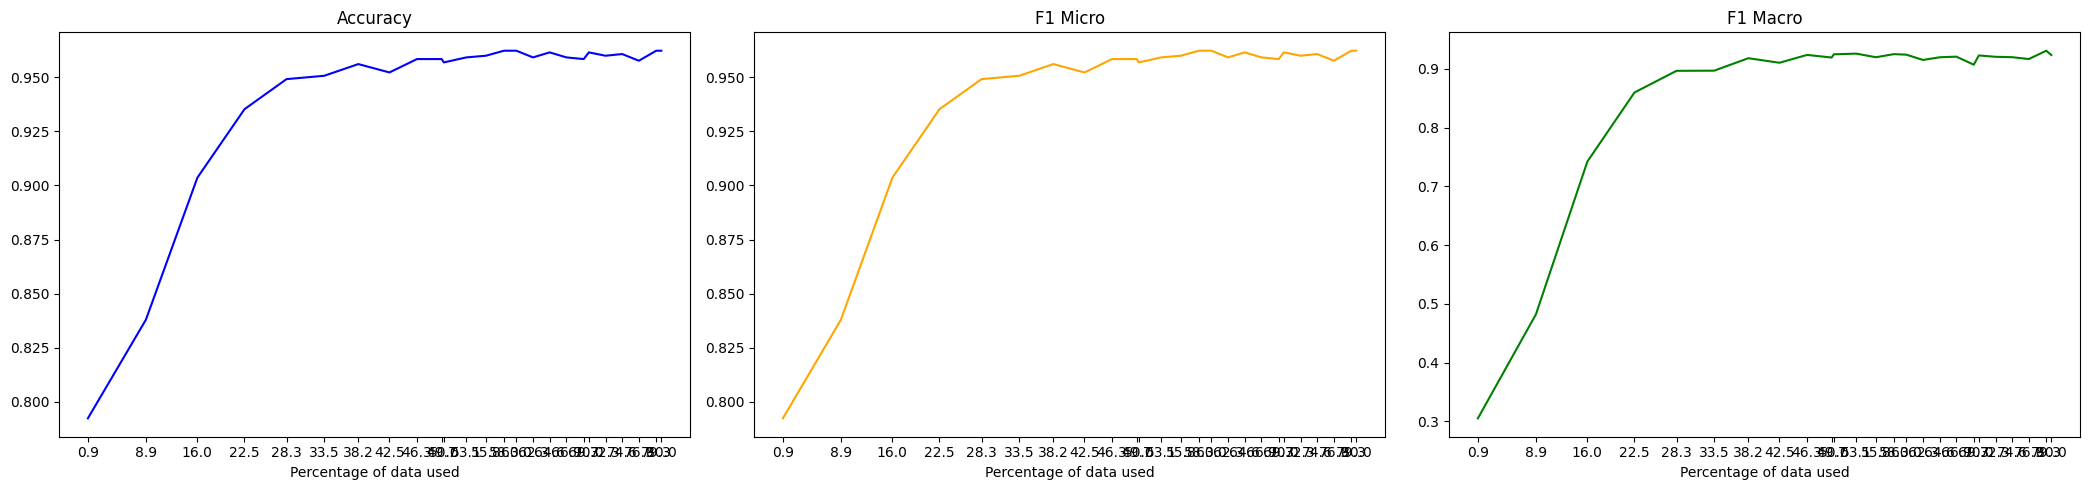

In [22]:
initial_train_size = int(0.01 * total_data)
active_learning(81, 0, 1)

Init Size 10
Random seed: 81
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6328, Accuracy: 0.7493, F1 Micro: 0.85, F1 Macro: 0.8204
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5334, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4951, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4625, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Epoch 5/10, Train Loss: 0.4453, Accuracy: 0.7894, F1 Micro: 0.8822, F1 Macro: 0.8807
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.4135, Accuracy: 0.7999, F1 Micro: 0.8872, F1 Macro: 0.8857
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3939, Accuracy: 0.8177, F1 Micro: 0.8959, F1 Macro: 0.8944
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3601, Accuracy: 0.846, F1 Micro: 0.91, F1 Macro: 0.9084
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.3088, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.647, Accuracy: 0.743, F1 Micro: 0.743, F1 Macro: 0.4466
Epoch 2/10, Train Loss: 0.5679, Accuracy: 0.7374, F1 Micro: 0.7374, F1 Macro: 0.4244
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.5035, Accuracy: 0.743, F1 Micro: 0.743, F1 Macro: 0.4466
Epoch 4/10, Train Loss: 0.4771, Accuracy: 0.7318, F1 Micro: 0.7318, F1 Macro: 0.5318
Epoch 5/10, Train Loss: 0.4109, Accuracy: 0.7263, F1 Micro: 0.7263, F1 Macro: 0.622
Epoch 6/10, Train Loss: 0.3137, Accuracy: 0.7263, F1 Micro: 0.7263, F1 Macro: 0.6489
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.267, Accuracy: 0.743, F1 Micro: 0.743, F1 Macro: 0.704
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1947, Accuracy: 0.7821, F1 Micro: 0.7821, F1 Macro: 0.7454
Epoch 9/10, Train Loss: 0.1264, Accuracy: 0.7765, F1 Micro: 0.7765, F1 Macro: 0.7258
Epoch 10/10, Train Loss: 0.0975, Accuracy: 0.7542, F1 Micro: 0.7542, F1 Macro: 0.7018

Sentiment analysis accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.61, Accuracy: 0.7894, F1 Micro: 0.8821, F1 Macro: 0.8806


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.516, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.5068, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4488, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4293, Accuracy: 0.814, F1 Micro: 0.8944, F1 Macro: 0.893
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3864, Accuracy: 0.8661, F1 Micro: 0.9211, F1 Macro: 0.92
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3406, Accuracy: 0.9003, F1 Micro: 0.9394, F1 Macro: 0.9376
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2843, Accuracy: 0.9182, F1 Micro: 0.9495, F1 Macro: 0.9473
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2472, Accuracy: 0.9241, F1 Micro: 0.9531, F1 Macro: 0.9511
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.2

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5502, Accuracy: 0.6786, F1 Micro: 0.6786, F1 Macro: 0.4043
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5282, Accuracy: 0.7009, F1 Micro: 0.7009, F1 Macro: 0.4852
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4189, Accuracy: 0.8259, F1 Micro: 0.8259, F1 Macro: 0.795
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2436, Accuracy: 0.8795, F1 Micro: 0.8795, F1 Macro: 0.8642
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1804, Accuracy: 0.8795, F1 Micro: 0.8795, F1 Macro: 0.866
Epoch 6/10, Train Loss: 0.1129, Accuracy: 0.8661, F1 Micro: 0.8661, F1 Macro: 0.8525
Epoch 7/10, Train Loss: 0.0964, Accuracy: 0.8705, F1 Micro: 0.8705, F1 Macro: 0.8578
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1087, Accuracy: 0.8795, F1 Micro: 0.8795, F1 Macro: 0.8668
Epoch 9/10, Train Loss: 0.0778, Accuracy: 0.875, F1 Micro: 0.875, F1 Macro: 0.8545
Higher F1 achieved, saving model
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5921, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4957, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4927, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.449, Accuracy: 0.8006, F1 Micro: 0.8878, F1 Macro: 0.8862
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3921, Accuracy: 0.8698, F1 Micro: 0.9233, F1 Macro: 0.9222
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3407, Accuracy: 0.8951, F1 Micro: 0.9352, F1 Macro: 0.9329
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2886, Accuracy: 0.9159, F1 Micro: 0.9478, F1 Macro: 0.9452
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2409, Accuracy: 0.9308, F1 Micro: 0.9568, F1 Macro: 0.9549
Higher F1 achieved, saving model
Epoch 9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6434, Accuracy: 0.6722, F1 Micro: 0.6722, F1 Macro: 0.402
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5682, Accuracy: 0.7759, F1 Micro: 0.7759, F1 Macro: 0.7128
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3527, Accuracy: 0.8423, F1 Micro: 0.8423, F1 Macro: 0.83
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2397, Accuracy: 0.8755, F1 Micro: 0.8755, F1 Macro: 0.8559
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1405, Accuracy: 0.8921, F1 Micro: 0.8921, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1686, Accuracy: 0.9004, F1 Micro: 0.9004, F1 Macro: 0.8897
Epoch 7/10, Train Loss: 0.0728, Accuracy: 0.8963, F1 Micro: 0.8963, F1 Macro: 0.8861
Epoch 8/10, Train Loss: 0.0748, Accuracy: 0.888, F1 Micro: 0.888, F1 Macro: 0.8763
Epoch 9/10, Train Loss: 0.0897, Accuracy: 0.8755, F1 Micro: 0.8755, F1 Macro: 0.8629
Epoch 10/10, Train Loss: 0.0485, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5641, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4972, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4588, Accuracy: 0.7954, F1 Micro: 0.8853, F1 Macro: 0.8838
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4019, Accuracy: 0.8743, F1 Micro: 0.9258, F1 Macro: 0.9245
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3355, Accuracy: 0.9085, F1 Micro: 0.9433, F1 Macro: 0.9406
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2769, Accuracy: 0.9271, F1 Micro: 0.9544, F1 Macro: 0.9516
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2097, Accuracy: 0.9479, F1 Micro: 0.9676, F1 Macro: 0.9661
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.177, Accuracy: 0.9516, F1 Micro: 0.9699, F1 Macro: 0.9684
Higher F1 achieved, saving model
Epoch 9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6326, Accuracy: 0.6694, F1 Micro: 0.6694, F1 Macro: 0.401
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5638, Accuracy: 0.8653, F1 Micro: 0.8653, F1 Macro: 0.8474
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3364, Accuracy: 0.9184, F1 Micro: 0.9184, F1 Macro: 0.9113
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2125, Accuracy: 0.9429, F1 Micro: 0.9429, F1 Macro: 0.935
Epoch 5/10, Train Loss: 0.1851, Accuracy: 0.9306, F1 Micro: 0.9306, F1 Macro: 0.9192
Epoch 6/10, Train Loss: 0.1387, Accuracy: 0.9143, F1 Micro: 0.9143, F1 Macro: 0.9067
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.101, Accuracy: 0.9429, F1 Micro: 0.9429, F1 Macro: 0.9358
Epoch 8/10, Train Loss: 0.0914, Accuracy: 0.9184, F1 Micro: 0.9184, F1 Macro: 0.9066
Epoch 9/10, Train Loss: 0.1178, Accuracy: 0.9143, F1 Micro: 0.9143, F1 Macro: 0.9067
Epoch 10/10, Train Loss: 0.0496, Accuracy: 0.9184, F1 Micro: 0.9184, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5597, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.492, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4458, Accuracy: 0.8296, F1 Micro: 0.9024, F1 Macro: 0.9016
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3541, Accuracy: 0.907, F1 Micro: 0.9427, F1 Macro: 0.9406
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2725, Accuracy: 0.9427, F1 Micro: 0.9645, F1 Macro: 0.9629
Epoch 6/10, Train Loss: 0.2147, Accuracy: 0.939, F1 Micro: 0.9619, F1 Macro: 0.9594
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1754, Accuracy: 0.9539, F1 Micro: 0.9712, F1 Macro: 0.9696
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1367, Accuracy: 0.9568, F1 Micro: 0.9729, F1 Macro: 0.9714
Epoch 9/10, Train Loss: 0.1064, Accuracy: 0.9539, F1 Micro: 0.971, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6696, Accuracy: 0.6586, F1 Micro: 0.6586, F1 Macro: 0.4472
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5231, Accuracy: 0.8795, F1 Micro: 0.8795, F1 Macro: 0.8689
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3221, Accuracy: 0.9197, F1 Micro: 0.9197, F1 Macro: 0.9142
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2192, Accuracy: 0.9317, F1 Micro: 0.9317, F1 Macro: 0.9266
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1764, Accuracy: 0.9317, F1 Micro: 0.9317, F1 Macro: 0.9262
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1505, Accuracy: 0.9357, F1 Micro: 0.9357, F1 Macro: 0.9268
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.162, Accuracy: 0.9398, F1 Micro: 0.9398, F1 Macro: 0.9336
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1533, Accuracy: 0.9398, F1 Micro: 0.9398, F1 Macro: 0.9339
Epoch 9/10, Train Loss: 0.1099, Accuracy: 0.9317, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.563, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4849, Accuracy: 0.7917, F1 Micro: 0.8834, F1 Macro: 0.882
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4025, Accuracy: 0.8943, F1 Micro: 0.9363, F1 Macro: 0.9349
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3165, Accuracy: 0.9234, F1 Micro: 0.9523, F1 Macro: 0.9494
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2439, Accuracy: 0.9479, F1 Micro: 0.9675, F1 Macro: 0.9659
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1884, Accuracy: 0.9531, F1 Micro: 0.9707, F1 Macro: 0.9692
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1383, Accuracy: 0.9606, F1 Micro: 0.9753, F1 Macro: 0.9738
Epoch 8/10, Train Loss: 0.1147, Accuracy: 0.9583, F1 Micro: 0.9739, F1 Macro: 0.9727
Epoch 9/10, Train Loss: 0.0947, Accuracy: 0.9598, F1 Micro: 0.9748, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6711, Accuracy: 0.752, F1 Micro: 0.752, F1 Macro: 0.6869
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.493, Accuracy: 0.916, F1 Micro: 0.916, F1 Macro: 0.9067
Epoch 3/10, Train Loss: 0.2468, Accuracy: 0.908, F1 Micro: 0.908, F1 Macro: 0.9026
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2058, Accuracy: 0.936, F1 Micro: 0.936, F1 Macro: 0.9283
Epoch 5/10, Train Loss: 0.1871, Accuracy: 0.928, F1 Micro: 0.928, F1 Macro: 0.9178
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1395, Accuracy: 0.94, F1 Micro: 0.94, F1 Macro: 0.9313
Epoch 7/10, Train Loss: 0.1388, Accuracy: 0.936, F1 Micro: 0.936, F1 Macro: 0.9295
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1342, Accuracy: 0.948, F1 Micro: 0.948, F1 Macro: 0.9432
Epoch 9/10, Train Loss: 0.0921, Accuracy: 0.94, F1 Micro: 0.94, F1 Macro: 0.9344
Epoch 10/10, Train Loss: 0.0636, Accuracy: 0.94, F1 Micro: 0.94, F1 Macro: 0.9341

Sentiment 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5694, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4857, Accuracy: 0.8058, F1 Micro: 0.8905, F1 Macro: 0.8892
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3837, Accuracy: 0.904, F1 Micro: 0.9414, F1 Macro: 0.94
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3021, Accuracy: 0.9345, F1 Micro: 0.9593, F1 Macro: 0.9577
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.229, Accuracy: 0.9546, F1 Micro: 0.9717, F1 Macro: 0.9698
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.175, Accuracy: 0.9591, F1 Micro: 0.9745, F1 Macro: 0.9731
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1275, Accuracy: 0.9598, F1 Micro: 0.9748, F1 Macro: 0.9732
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1119, Accuracy: 0.9643, F1 Micro: 0.9776, F1 Macro: 0.9763
Epoch 9/10, Train Loss: 0.0927, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6555, Accuracy: 0.6653, F1 Micro: 0.6653, F1 Macro: 0.4107
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4344, Accuracy: 0.9243, F1 Micro: 0.9243, F1 Macro: 0.9167
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2812, Accuracy: 0.9243, F1 Micro: 0.9243, F1 Macro: 0.9153
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2242, Accuracy: 0.9402, F1 Micro: 0.9402, F1 Macro: 0.9342
Epoch 5/10, Train Loss: 0.1865, Accuracy: 0.9363, F1 Micro: 0.9363, F1 Macro: 0.9284
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1613, Accuracy: 0.9522, F1 Micro: 0.9522, F1 Macro: 0.9472
Epoch 7/10, Train Loss: 0.116, Accuracy: 0.9402, F1 Micro: 0.9402, F1 Macro: 0.9346
Epoch 8/10, Train Loss: 0.0929, Accuracy: 0.9363, F1 Micro: 0.9363, F1 Macro: 0.9307
Epoch 9/10, Train Loss: 0.0843, Accuracy: 0.9323, F1 Micro: 0.9323, F1 Macro: 0.9266
Epoch 10/10, Train Loss: 0.0821, Accuracy: 0.9402, F1 Micro: 0.9402, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.549, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4686, Accuracy: 0.817, F1 Micro: 0.896, F1 Macro: 0.8953
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3657, Accuracy: 0.907, F1 Micro: 0.942, F1 Macro: 0.9397
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2721, Accuracy: 0.9427, F1 Micro: 0.9646, F1 Macro: 0.9634
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1956, Accuracy: 0.9554, F1 Micro: 0.9723, F1 Macro: 0.9712
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1508, Accuracy: 0.9613, F1 Micro: 0.9758, F1 Macro: 0.9745
Epoch 7/10, Train Loss: 0.1254, Accuracy: 0.9583, F1 Micro: 0.974, F1 Macro: 0.9729
Epoch 8/10, Train Loss: 0.0994, Accuracy: 0.9606, F1 Micro: 0.9754, F1 Macro: 0.974
Epoch 9/10, Train Loss: 0.0863, Accuracy: 0.9576, F1 Micro: 0.9734, F1 Macro: 0.9717
Epoch 10/10, Train Loss: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6516, Accuracy: 0.7602, F1 Micro: 0.7602, F1 Macro: 0.6767
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4214, Accuracy: 0.9309, F1 Micro: 0.9309, F1 Macro: 0.925
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2398, Accuracy: 0.9593, F1 Micro: 0.9593, F1 Macro: 0.9555
Epoch 4/10, Train Loss: 0.206, Accuracy: 0.9512, F1 Micro: 0.9512, F1 Macro: 0.9464
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1729, Accuracy: 0.9634, F1 Micro: 0.9634, F1 Macro: 0.9594
Epoch 6/10, Train Loss: 0.155, Accuracy: 0.9472, F1 Micro: 0.9472, F1 Macro: 0.9426
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.075, Accuracy: 0.9675, F1 Micro: 0.9675, F1 Macro: 0.9642
Epoch 8/10, Train Loss: 0.1337, Accuracy: 0.9146, F1 Micro: 0.9146, F1 Macro: 0.9098
Epoch 9/10, Train Loss: 0.1061, Accuracy: 0.9634, F1 Micro: 0.9634, F1 Macro: 0.9599
Epoch 10/10, Train Loss: 0.0953, Accuracy: 0.9553, F1 Micro: 0.9553, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.539, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4731, Accuracy: 0.8385, F1 Micro: 0.9071, F1 Macro: 0.9064
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.353, Accuracy: 0.904, F1 Micro: 0.94, F1 Macro: 0.9369
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2601, Accuracy: 0.9353, F1 Micro: 0.9594, F1 Macro: 0.9564
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.194, Accuracy: 0.9546, F1 Micro: 0.9717, F1 Macro: 0.9706
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1484, Accuracy: 0.9613, F1 Micro: 0.9757, F1 Macro: 0.9743
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.115, Accuracy: 0.9643, F1 Micro: 0.9777, F1 Macro: 0.9766
Epoch 8/10, Train Loss: 0.0897, Accuracy: 0.9568, F1 Micro: 0.9728, F1 Macro: 0.9703
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0817, Accuracy: 0.96

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6133, Accuracy: 0.8268, F1 Micro: 0.8268, F1 Macro: 0.7831
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3549, Accuracy: 0.9291, F1 Micro: 0.9291, F1 Macro: 0.9204
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2157, Accuracy: 0.9291, F1 Micro: 0.9291, F1 Macro: 0.9229
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1588, Accuracy: 0.9409, F1 Micro: 0.9409, F1 Macro: 0.9353
Epoch 5/10, Train Loss: 0.1378, Accuracy: 0.937, F1 Micro: 0.937, F1 Macro: 0.9289
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1572, Accuracy: 0.9449, F1 Micro: 0.9449, F1 Macro: 0.9381
Epoch 7/10, Train Loss: 0.0972, Accuracy: 0.9409, F1 Micro: 0.9409, F1 Macro: 0.9331
Epoch 8/10, Train Loss: 0.0817, Accuracy: 0.9409, F1 Micro: 0.9409, F1 Macro: 0.935
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0739, Accuracy: 0.9449, F1 Micro: 0.9449, F1 Macro: 0.9388
Higher F1 achieved, saving model
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5406, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4545, Accuracy: 0.8408, F1 Micro: 0.9082, F1 Macro: 0.9074
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3402, Accuracy: 0.9293, F1 Micro: 0.9565, F1 Macro: 0.9546
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2468, Accuracy: 0.9487, F1 Micro: 0.9681, F1 Macro: 0.967
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1885, Accuracy: 0.9583, F1 Micro: 0.9739, F1 Macro: 0.9725
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.136, Accuracy: 0.9621, F1 Micro: 0.9762, F1 Macro: 0.9746
Epoch 7/10, Train Loss: 0.1107, Accuracy: 0.9583, F1 Micro: 0.9738, F1 Macro: 0.9722
Epoch 8/10, Train Loss: 0.0907, Accuracy: 0.9554, F1 Micro: 0.9718, F1 Macro: 0.9693
Epoch 9/10, Train Loss: 0.0751, Accuracy: 0.9621, F1 Micro: 0.9761, F1 Macro: 0.9743
Epoch 10/10, Train Los

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6016, Accuracy: 0.875, F1 Micro: 0.875, F1 Macro: 0.8591
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3295, Accuracy: 0.9453, F1 Micro: 0.9453, F1 Macro: 0.9391
Epoch 3/10, Train Loss: 0.2089, Accuracy: 0.9062, F1 Micro: 0.9062, F1 Macro: 0.8869
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2007, Accuracy: 0.9492, F1 Micro: 0.9492, F1 Macro: 0.9422
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1345, Accuracy: 0.9531, F1 Micro: 0.9531, F1 Macro: 0.9468
Epoch 6/10, Train Loss: 0.1131, Accuracy: 0.9453, F1 Micro: 0.9453, F1 Macro: 0.938
Epoch 7/10, Train Loss: 0.0905, Accuracy: 0.9375, F1 Micro: 0.9375, F1 Macro: 0.9311
Epoch 8/10, Train Loss: 0.0667, Accuracy: 0.9336, F1 Micro: 0.9336, F1 Macro: 0.9274
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0721, Accuracy: 0.9531, F1 Micro: 0.9531, F1 Macro: 0.9475
Epoch 10/10, Train Loss: 0.046, Accuracy: 0.9453, F1 Micro: 0.9453, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5422, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4396, Accuracy: 0.8847, F1 Micro: 0.9317, F1 Macro: 0.9307
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3136, Accuracy: 0.9405, F1 Micro: 0.9633, F1 Macro: 0.9614
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2203, Accuracy: 0.9576, F1 Micro: 0.9736, F1 Macro: 0.9723
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1619, Accuracy: 0.9613, F1 Micro: 0.9758, F1 Macro: 0.9743
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.122, Accuracy: 0.9628, F1 Micro: 0.9766, F1 Macro: 0.9748
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0961, Accuracy: 0.9628, F1 Micro: 0.9766, F1 Macro: 0.975
Epoch 8/10, Train Loss: 0.076, Accuracy: 0.9621, F1 Micro: 0.9761, F1 Macro: 0.9742
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0627, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6019, Accuracy: 0.8851, F1 Micro: 0.8851, F1 Macro: 0.8707
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2779, Accuracy: 0.9387, F1 Micro: 0.9387, F1 Macro: 0.9325
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2052, Accuracy: 0.9387, F1 Micro: 0.9387, F1 Macro: 0.9302
Epoch 4/10, Train Loss: 0.1607, Accuracy: 0.931, F1 Micro: 0.931, F1 Macro: 0.9224
Epoch 5/10, Train Loss: 0.1316, Accuracy: 0.9349, F1 Micro: 0.9349, F1 Macro: 0.9277
Epoch 6/10, Train Loss: 0.1271, Accuracy: 0.9349, F1 Micro: 0.9349, F1 Macro: 0.9277
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0873, Accuracy: 0.9387, F1 Micro: 0.9387, F1 Macro: 0.9322
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0848, Accuracy: 0.9464, F1 Micro: 0.9464, F1 Macro: 0.9403
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1095, Accuracy: 0.9464, F1 Micro: 0.9464, F1 Macro: 0.9397
Higher F1 achieved, saving model
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5389, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4298, Accuracy: 0.8824, F1 Micro: 0.9297, F1 Macro: 0.9289
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3047, Accuracy: 0.9412, F1 Micro: 0.9636, F1 Macro: 0.9623
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2103, Accuracy: 0.9516, F1 Micro: 0.9697, F1 Macro: 0.9683
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1601, Accuracy: 0.9606, F1 Micro: 0.9753, F1 Macro: 0.9738
Epoch 6/10, Train Loss: 0.1207, Accuracy: 0.9583, F1 Micro: 0.9738, F1 Macro: 0.9715
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.108, Accuracy: 0.9673, F1 Micro: 0.9796, F1 Macro: 0.9787
Epoch 8/10, Train Loss: 0.0792, Accuracy: 0.9568, F1 Micro: 0.9727, F1 Macro: 0.9702
Epoch 9/10, Train Loss: 0.068, Accuracy: 0.9606, F1 Micro: 0.9753, F1 Macro: 0.9738
Epoch 10/10, Train Los

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6025, Accuracy: 0.8642, F1 Micro: 0.8642, F1 Macro: 0.8467
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3267, Accuracy: 0.9383, F1 Micro: 0.9383, F1 Macro: 0.9327
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1913, Accuracy: 0.9588, F1 Micro: 0.9588, F1 Macro: 0.955
Epoch 4/10, Train Loss: 0.1482, Accuracy: 0.9465, F1 Micro: 0.9465, F1 Macro: 0.9407
Epoch 5/10, Train Loss: 0.1741, Accuracy: 0.9465, F1 Micro: 0.9465, F1 Macro: 0.9417
Epoch 6/10, Train Loss: 0.128, Accuracy: 0.9465, F1 Micro: 0.9465, F1 Macro: 0.942
Epoch 7/10, Train Loss: 0.1055, Accuracy: 0.9465, F1 Micro: 0.9465, F1 Macro: 0.942
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0836, Accuracy: 0.9588, F1 Micro: 0.9588, F1 Macro: 0.9545
Epoch 9/10, Train Loss: 0.0661, Accuracy: 0.9506, F1 Micro: 0.9506, F1 Macro: 0.946
Epoch 10/10, Train Loss: 0.0642, Accuracy: 0.9547, F1 Micro: 0.9547, F1 Macro: 0.9504

Sentiment analysis ac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5345, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4263, Accuracy: 0.91, F1 Micro: 0.9449, F1 Macro: 0.9429
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2909, Accuracy: 0.9487, F1 Micro: 0.9682, F1 Macro: 0.9669
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2013, Accuracy: 0.9568, F1 Micro: 0.9732, F1 Macro: 0.9722
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1503, Accuracy: 0.9583, F1 Micro: 0.9737, F1 Macro: 0.9719
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1119, Accuracy: 0.9606, F1 Micro: 0.9751, F1 Macro: 0.9729
Epoch 7/10, Train Loss: 0.0888, Accuracy: 0.9598, F1 Micro: 0.9746, F1 Macro: 0.9721
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0728, Accuracy: 0.9613, F1 Micro: 0.9755, F1 Macro: 0.9731
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0597, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5742, Accuracy: 0.8614, F1 Micro: 0.8614, F1 Macro: 0.8408
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2728, Accuracy: 0.8876, F1 Micro: 0.8876, F1 Macro: 0.8791
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1886, Accuracy: 0.9251, F1 Micro: 0.9251, F1 Macro: 0.9175
Epoch 4/10, Train Loss: 0.182, Accuracy: 0.9139, F1 Micro: 0.9139, F1 Macro: 0.9058
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.145, Accuracy: 0.9326, F1 Micro: 0.9326, F1 Macro: 0.9237
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1082, Accuracy: 0.9326, F1 Micro: 0.9326, F1 Macro: 0.9223
Epoch 7/10, Train Loss: 0.105, Accuracy: 0.9139, F1 Micro: 0.9139, F1 Macro: 0.9011
Epoch 8/10, Train Loss: 0.0964, Accuracy: 0.9213, F1 Micro: 0.9213, F1 Macro: 0.9097
Epoch 9/10, Train Loss: 0.0638, Accuracy: 0.9288, F1 Micro: 0.9288, F1 Macro: 0.921
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0838, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5414, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4068, Accuracy: 0.91, F1 Micro: 0.945, F1 Macro: 0.9433
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.276, Accuracy: 0.9435, F1 Micro: 0.9649, F1 Macro: 0.9628
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2068, Accuracy: 0.9561, F1 Micro: 0.9726, F1 Macro: 0.9711
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1446, Accuracy: 0.9606, F1 Micro: 0.9753, F1 Macro: 0.974
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1108, Accuracy: 0.9658, F1 Micro: 0.9785, F1 Macro: 0.9773
Epoch 7/10, Train Loss: 0.0877, Accuracy: 0.9635, F1 Micro: 0.977, F1 Macro: 0.975
Epoch 8/10, Train Loss: 0.0699, Accuracy: 0.9598, F1 Micro: 0.9746, F1 Macro: 0.9717
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0623, Accuracy: 0.968, F1 Micro: 0.9799, F1 Macro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5777, Accuracy: 0.722, F1 Micro: 0.722, F1 Macro: 0.5951
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3446, Accuracy: 0.8919, F1 Micro: 0.8919, F1 Macro: 0.8855
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2058, Accuracy: 0.9266, F1 Micro: 0.9266, F1 Macro: 0.9197
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1896, Accuracy: 0.9266, F1 Micro: 0.9266, F1 Macro: 0.9205
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1506, Accuracy: 0.9382, F1 Micro: 0.9382, F1 Macro: 0.9322
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1196, Accuracy: 0.9459, F1 Micro: 0.9459, F1 Macro: 0.9401
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0937, Accuracy: 0.9498, F1 Micro: 0.9498, F1 Macro: 0.9445
Epoch 8/10, Train Loss: 0.0715, Accuracy: 0.9344, F1 Micro: 0.9344, F1 Macro: 0.9285
Epoch 9/10, Train Loss: 0.078, Accuracy: 0.9459, F1 Micro: 0.9459, F1 Macro: 0.9401
Higher 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5246, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4045, Accuracy: 0.9018, F1 Micro: 0.9394, F1 Macro: 0.9372
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2775, Accuracy: 0.9435, F1 Micro: 0.9647, F1 Macro: 0.9627
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1908, Accuracy: 0.9591, F1 Micro: 0.9743, F1 Macro: 0.9728
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1439, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Macro: 0.9758
Epoch 6/10, Train Loss: 0.1045, Accuracy: 0.9583, F1 Micro: 0.9737, F1 Macro: 0.9716
Epoch 7/10, Train Loss: 0.0883, Accuracy: 0.9621, F1 Micro: 0.9761, F1 Macro: 0.974
Epoch 8/10, Train Loss: 0.0677, Accuracy: 0.9621, F1 Micro: 0.976, F1 Macro: 0.9737
Epoch 9/10, Train Loss: 0.0602, Accuracy: 0.9591, F1 Micro: 0.9742, F1 Macro: 0.9717
Higher F1 achieved, saving model
Epoch 10/10, Train Los

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5187, Accuracy: 0.8927, F1 Micro: 0.8927, F1 Macro: 0.8825
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2711, Accuracy: 0.9272, F1 Micro: 0.9272, F1 Macro: 0.9174
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1871, Accuracy: 0.931, F1 Micro: 0.931, F1 Macro: 0.9229
Epoch 4/10, Train Loss: 0.1473, Accuracy: 0.9234, F1 Micro: 0.9234, F1 Macro: 0.9165
Epoch 5/10, Train Loss: 0.1282, Accuracy: 0.9234, F1 Micro: 0.9234, F1 Macro: 0.9165
Epoch 6/10, Train Loss: 0.1128, Accuracy: 0.9272, F1 Micro: 0.9272, F1 Macro: 0.9197
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0719, Accuracy: 0.9349, F1 Micro: 0.9349, F1 Macro: 0.9281
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1117, Accuracy: 0.9425, F1 Micro: 0.9425, F1 Macro: 0.9355
Epoch 9/10, Train Loss: 0.0875, Accuracy: 0.9387, F1 Micro: 0.9387, F1 Macro: 0.9322
Epoch 10/10, Train Loss: 0.0583, Accuracy: 0.9119, F1 Micro: 0.9119, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5298, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3978, Accuracy: 0.9226, F1 Micro: 0.9523, F1 Macro: 0.9503
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2622, Accuracy: 0.9546, F1 Micro: 0.9719, F1 Macro: 0.9708
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1837, Accuracy: 0.9606, F1 Micro: 0.9753, F1 Macro: 0.9737
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1399, Accuracy: 0.9613, F1 Micro: 0.9757, F1 Macro: 0.9741
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1078, Accuracy: 0.9658, F1 Micro: 0.9785, F1 Macro: 0.9773
Epoch 7/10, Train Loss: 0.0794, Accuracy: 0.9583, F1 Micro: 0.9737, F1 Macro: 0.9709
Epoch 8/10, Train Loss: 0.0682, Accuracy: 0.9658, F1 Micro: 0.9784, F1 Macro: 0.9768
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0543, Accuracy: 0.968, F1 Micro: 0.9797, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5559, Accuracy: 0.8759, F1 Micro: 0.8759, F1 Macro: 0.855
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2851, Accuracy: 0.9234, F1 Micro: 0.9234, F1 Macro: 0.9152
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1911, Accuracy: 0.938, F1 Micro: 0.938, F1 Macro: 0.9303
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1501, Accuracy: 0.938, F1 Micro: 0.938, F1 Macro: 0.9286
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1372, Accuracy: 0.938, F1 Micro: 0.938, F1 Macro: 0.9291
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1394, Accuracy: 0.938, F1 Micro: 0.938, F1 Macro: 0.9306
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1082, Accuracy: 0.9416, F1 Micro: 0.9416, F1 Macro: 0.9345
Epoch 8/10, Train Loss: 0.0829, Accuracy: 0.9343, F1 Micro: 0.9343, F1 Macro: 0.926
Epoch 9/10, Train Loss: 0.0875, Accuracy: 0.9343, F1 Micro: 0.9343, F1 Macro: 0.9268
Epoch 10/10, T

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5297, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3987, Accuracy: 0.9211, F1 Micro: 0.9507, F1 Macro: 0.9478
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2586, Accuracy: 0.9516, F1 Micro: 0.9701, F1 Macro: 0.969
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1773, Accuracy: 0.9606, F1 Micro: 0.9754, F1 Macro: 0.9744
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1302, Accuracy: 0.9628, F1 Micro: 0.9767, F1 Macro: 0.9756
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0922, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0.9767
Epoch 7/10, Train Loss: 0.077, Accuracy: 0.9628, F1 Micro: 0.9765, F1 Macro: 0.9745
Epoch 8/10, Train Loss: 0.064, Accuracy: 0.9635, F1 Micro: 0.977, F1 Macro: 0.9754
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0565, Accuracy: 0.9658, F1 Micro: 0.9785, F1 Macro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5272, Accuracy: 0.8851, F1 Micro: 0.8851, F1 Macro: 0.8753
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.284, Accuracy: 0.9425, F1 Micro: 0.9425, F1 Macro: 0.9366
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2122, Accuracy: 0.9464, F1 Micro: 0.9464, F1 Macro: 0.9412
Epoch 4/10, Train Loss: 0.1635, Accuracy: 0.931, F1 Micro: 0.931, F1 Macro: 0.9237
Epoch 5/10, Train Loss: 0.1357, Accuracy: 0.9387, F1 Micro: 0.9387, F1 Macro: 0.9329
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1406, Accuracy: 0.9464, F1 Micro: 0.9464, F1 Macro: 0.941
Epoch 7/10, Train Loss: 0.1279, Accuracy: 0.9195, F1 Micro: 0.9195, F1 Macro: 0.9092
Epoch 8/10, Train Loss: 0.1113, Accuracy: 0.9349, F1 Micro: 0.9349, F1 Macro: 0.9269
Epoch 9/10, Train Loss: 0.0773, Accuracy: 0.9387, F1 Micro: 0.9387, F1 Macro: 0.9325
Epoch 10/10, Train Loss: 0.062, Accuracy: 0.9272, F1 Micro: 0.9272, F1 Macro: 0.9201

Sentiment analysis ac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5206, Accuracy: 0.7909, F1 Micro: 0.8831, F1 Macro: 0.8816
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3832, Accuracy: 0.9196, F1 Micro: 0.9499, F1 Macro: 0.9466
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2537, Accuracy: 0.9509, F1 Micro: 0.9695, F1 Macro: 0.9681
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1797, Accuracy: 0.9583, F1 Micro: 0.974, F1 Macro: 0.9724
Epoch 5/10, Train Loss: 0.1329, Accuracy: 0.9576, F1 Micro: 0.9734, F1 Macro: 0.9716
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.102, Accuracy: 0.9628, F1 Micro: 0.9765, F1 Macro: 0.9747
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0765, Accuracy: 0.971, F1 Micro: 0.9818, F1 Macro: 0.9809
Epoch 8/10, Train Loss: 0.0644, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0.9767
Epoch 9/10, Train Loss: 0.051, Accuracy: 0.9606, F1 Micro: 0.9751, F1 Macro: 0.9733
Epoch 10/10, Train Loss: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5555, Accuracy: 0.873, F1 Micro: 0.873, F1 Macro: 0.8535
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2774, Accuracy: 0.9087, F1 Micro: 0.9087, F1 Macro: 0.9022
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2008, Accuracy: 0.9405, F1 Micro: 0.9405, F1 Macro: 0.935
Epoch 4/10, Train Loss: 0.1635, Accuracy: 0.9325, F1 Micro: 0.9325, F1 Macro: 0.9274
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1458, Accuracy: 0.9444, F1 Micro: 0.9444, F1 Macro: 0.9392
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.097, Accuracy: 0.9444, F1 Micro: 0.9444, F1 Macro: 0.9392
Epoch 7/10, Train Loss: 0.0805, Accuracy: 0.9365, F1 Micro: 0.9365, F1 Macro: 0.9305
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0922, Accuracy: 0.9484, F1 Micro: 0.9484, F1 Macro: 0.9437
Epoch 9/10, Train Loss: 0.0813, Accuracy: 0.9365, F1 Micro: 0.9365, F1 Macro: 0.929
Epoch 10/10, Train Loss: 0.0685, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5324, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3816, Accuracy: 0.9323, F1 Micro: 0.9578, F1 Macro: 0.9556
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2441, Accuracy: 0.9554, F1 Micro: 0.9723, F1 Macro: 0.9711
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1661, Accuracy: 0.9628, F1 Micro: 0.9767, F1 Macro: 0.9751
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1221, Accuracy: 0.965, F1 Micro: 0.9781, F1 Macro: 0.977
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.096, Accuracy: 0.9658, F1 Micro: 0.9784, F1 Macro: 0.9773
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0824, Accuracy: 0.968, F1 Micro: 0.9798, F1 Macro: 0.9784
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0662, Accuracy: 0.968, F1 Micro: 0.9799, F1 Macro: 0.9787
Higher F1 achieved, saving model
Epoch 9/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5091, Accuracy: 0.9004, F1 Micro: 0.9004, F1 Macro: 0.8903
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2475, Accuracy: 0.9234, F1 Micro: 0.9234, F1 Macro: 0.9138
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1862, Accuracy: 0.931, F1 Micro: 0.931, F1 Macro: 0.9245
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1525, Accuracy: 0.9387, F1 Micro: 0.9387, F1 Macro: 0.9332
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1255, Accuracy: 0.9387, F1 Micro: 0.9387, F1 Macro: 0.9314
Epoch 6/10, Train Loss: 0.1039, Accuracy: 0.9119, F1 Micro: 0.9119, F1 Macro: 0.905
Epoch 7/10, Train Loss: 0.1107, Accuracy: 0.9234, F1 Micro: 0.9234, F1 Macro: 0.9128
Epoch 8/10, Train Loss: 0.1063, Accuracy: 0.9234, F1 Micro: 0.9234, F1 Macro: 0.9161
Epoch 9/10, Train Loss: 0.0927, Accuracy: 0.9195, F1 Micro: 0.9195, F1 Macro: 0.9112
Epoch 10/10, Train Loss: 0.0642, Accuracy: 0.9349, F1 Micro: 0.9349, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5197, Accuracy: 0.7991, F1 Micro: 0.8871, F1 Macro: 0.8857
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3706, Accuracy: 0.9301, F1 Micro: 0.9568, F1 Macro: 0.9545
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2327, Accuracy: 0.9546, F1 Micro: 0.9719, F1 Macro: 0.9707
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1654, Accuracy: 0.9635, F1 Micro: 0.9772, F1 Macro: 0.9763
Epoch 5/10, Train Loss: 0.1179, Accuracy: 0.9635, F1 Micro: 0.9771, F1 Macro: 0.9759
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0911, Accuracy: 0.9702, F1 Micro: 0.9813, F1 Macro: 0.9803
Epoch 7/10, Train Loss: 0.0699, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0.9767
Epoch 8/10, Train Loss: 0.059, Accuracy: 0.968, F1 Micro: 0.9798, F1 Macro: 0.9785
Epoch 9/10, Train Loss: 0.0502, Accuracy: 0.9658, F1 Micro: 0.9784, F1 Macro: 0.9767
Epoch 10/10, Train Loss: 0.0424, Accuracy: 0.9635, F1 Mic

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5124, Accuracy: 0.898, F1 Micro: 0.898, F1 Macro: 0.891
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2267, Accuracy: 0.9373, F1 Micro: 0.9373, F1 Macro: 0.9298
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1556, Accuracy: 0.9373, F1 Micro: 0.9373, F1 Macro: 0.9294
Epoch 4/10, Train Loss: 0.1426, Accuracy: 0.9294, F1 Micro: 0.9294, F1 Macro: 0.9235
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0998, Accuracy: 0.9373, F1 Micro: 0.9373, F1 Macro: 0.931
Epoch 6/10, Train Loss: 0.0992, Accuracy: 0.9294, F1 Micro: 0.9294, F1 Macro: 0.9215
Epoch 7/10, Train Loss: 0.0977, Accuracy: 0.9294, F1 Micro: 0.9294, F1 Macro: 0.9223
Epoch 8/10, Train Loss: 0.0608, Accuracy: 0.9255, F1 Micro: 0.9255, F1 Macro: 0.9182
Epoch 9/10, Train Loss: 0.0741, Accuracy: 0.9255, F1 Micro: 0.9255, F1 Macro: 0.9182
Epoch 10/10, Train Loss: 0.0564, Accuracy: 0.9294, F1 Micro: 0.9294, F1 Macro: 0.9223

Sentiment analysis a

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.528, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3796, Accuracy: 0.9219, F1 Micro: 0.9511, F1 Macro: 0.9481
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2448, Accuracy: 0.9546, F1 Micro: 0.9717, F1 Macro: 0.9703
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1609, Accuracy: 0.9598, F1 Micro: 0.9749, F1 Macro: 0.9735
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1258, Accuracy: 0.9695, F1 Micro: 0.9808, F1 Macro: 0.9796
Epoch 6/10, Train Loss: 0.0958, Accuracy: 0.9598, F1 Micro: 0.9745, F1 Macro: 0.9718
Epoch 7/10, Train Loss: 0.0727, Accuracy: 0.9673, F1 Micro: 0.9793, F1 Macro: 0.9776
Epoch 8/10, Train Loss: 0.0628, Accuracy: 0.9673, F1 Micro: 0.9793, F1 Macro: 0.9781
Epoch 9/10, Train Loss: 0.052, Accuracy: 0.9688, F1 Micro: 0.9803, F1 Macro: 0.9791
Epoch 10/10, Train Loss: 0.0426, Accuracy: 0.9673, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5412, Accuracy: 0.8949, F1 Micro: 0.8949, F1 Macro: 0.8753
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.26, Accuracy: 0.9416, F1 Micro: 0.9416, F1 Macro: 0.9357
Epoch 3/10, Train Loss: 0.1767, Accuracy: 0.9261, F1 Micro: 0.9261, F1 Macro: 0.9198
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.108, Accuracy: 0.9494, F1 Micro: 0.9494, F1 Macro: 0.944
Epoch 5/10, Train Loss: 0.1424, Accuracy: 0.9377, F1 Micro: 0.9377, F1 Macro: 0.9297
Epoch 6/10, Train Loss: 0.1003, Accuracy: 0.9339, F1 Micro: 0.9339, F1 Macro: 0.9275
Epoch 7/10, Train Loss: 0.0743, Accuracy: 0.9377, F1 Micro: 0.9377, F1 Macro: 0.9316
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0778, Accuracy: 0.9494, F1 Micro: 0.9494, F1 Macro: 0.944
Epoch 9/10, Train Loss: 0.0671, Accuracy: 0.9377, F1 Micro: 0.9377, F1 Macro: 0.9316
Epoch 10/10, Train Loss: 0.0492, Accuracy: 0.9377, F1 Micro: 0.9377, F1 Macro: 0.9288

Sentiment analysis ac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5201, Accuracy: 0.7917, F1 Micro: 0.8834, F1 Macro: 0.882
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3649, Accuracy: 0.9293, F1 Micro: 0.9559, F1 Macro: 0.9531
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2384, Accuracy: 0.9568, F1 Micro: 0.9733, F1 Macro: 0.9721
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1517, Accuracy: 0.9613, F1 Micro: 0.9757, F1 Macro: 0.9743
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1202, Accuracy: 0.965, F1 Micro: 0.9781, F1 Macro: 0.9769
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0911, Accuracy: 0.968, F1 Micro: 0.9799, F1 Macro: 0.9787
Epoch 7/10, Train Loss: 0.0719, Accuracy: 0.9673, F1 Micro: 0.9794, F1 Macro: 0.9782
Epoch 8/10, Train Loss: 0.0581, Accuracy: 0.965, F1 Micro: 0.9779, F1 Macro: 0.9763
Epoch 9/10, Train Loss: 0.0497, Accuracy: 0.9643, F1 Micro: 0.9774, F1 Macro: 0.9753
Higher F1 achieved, savi

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4864, Accuracy: 0.924, F1 Micro: 0.924, F1 Macro: 0.9146
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2007, Accuracy: 0.9392, F1 Micro: 0.9392, F1 Macro: 0.9321
Epoch 3/10, Train Loss: 0.1673, Accuracy: 0.9316, F1 Micro: 0.9316, F1 Macro: 0.924
Epoch 4/10, Train Loss: 0.1029, Accuracy: 0.9163, F1 Micro: 0.9163, F1 Macro: 0.9089
Epoch 5/10, Train Loss: 0.1252, Accuracy: 0.9278, F1 Micro: 0.9278, F1 Macro: 0.9208
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1005, Accuracy: 0.943, F1 Micro: 0.943, F1 Macro: 0.9368
Epoch 7/10, Train Loss: 0.083, Accuracy: 0.9278, F1 Micro: 0.9278, F1 Macro: 0.9208
Epoch 8/10, Train Loss: 0.0915, Accuracy: 0.9278, F1 Micro: 0.9278, F1 Macro: 0.9204
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0557, Accuracy: 0.943, F1 Micro: 0.943, F1 Macro: 0.9361
Epoch 10/10, Train Loss: 0.0573, Accuracy: 0.924, F1 Micro: 0.924, F1 Macro: 0.916

Sentiment analysis accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5146, Accuracy: 0.7909, F1 Micro: 0.8831, F1 Macro: 0.8816
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3627, Accuracy: 0.9323, F1 Micro: 0.958, F1 Macro: 0.9556
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2346, Accuracy: 0.9568, F1 Micro: 0.9733, F1 Macro: 0.9722
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1568, Accuracy: 0.9606, F1 Micro: 0.9752, F1 Macro: 0.9734
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1164, Accuracy: 0.9665, F1 Micro: 0.979, F1 Macro: 0.9781
Epoch 6/10, Train Loss: 0.0928, Accuracy: 0.965, F1 Micro: 0.9779, F1 Macro: 0.9763
Epoch 7/10, Train Loss: 0.0738, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro: 0.9775
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0564, Accuracy: 0.9673, F1 Micro: 0.9794, F1 Macro: 0.978
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0461, Accuracy: 0.9702, F1 Micro: 0.9812, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5386, Accuracy: 0.8951, F1 Micro: 0.8951, F1 Macro: 0.8845
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2188, Accuracy: 0.9176, F1 Micro: 0.9176, F1 Macro: 0.9109
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1655, Accuracy: 0.9476, F1 Micro: 0.9476, F1 Macro: 0.9423
Epoch 4/10, Train Loss: 0.1451, Accuracy: 0.9213, F1 Micro: 0.9213, F1 Macro: 0.914
Epoch 5/10, Train Loss: 0.1279, Accuracy: 0.9363, F1 Micro: 0.9363, F1 Macro: 0.9286
Epoch 6/10, Train Loss: 0.1127, Accuracy: 0.9139, F1 Micro: 0.9139, F1 Macro: 0.9067
Epoch 7/10, Train Loss: 0.1169, Accuracy: 0.9176, F1 Micro: 0.9176, F1 Macro: 0.9105
Epoch 8/10, Train Loss: 0.09, Accuracy: 0.9288, F1 Micro: 0.9288, F1 Macro: 0.9202
Epoch 9/10, Train Loss: 0.0702, Accuracy: 0.9401, F1 Micro: 0.9401, F1 Macro: 0.9333
Epoch 10/10, Train Loss: 0.0564, Accuracy: 0.9363, F1 Micro: 0.9363, F1 Macro: 0.9293

Sentiment analysis accuracy: 0.9476, F1 Micro: 0.947

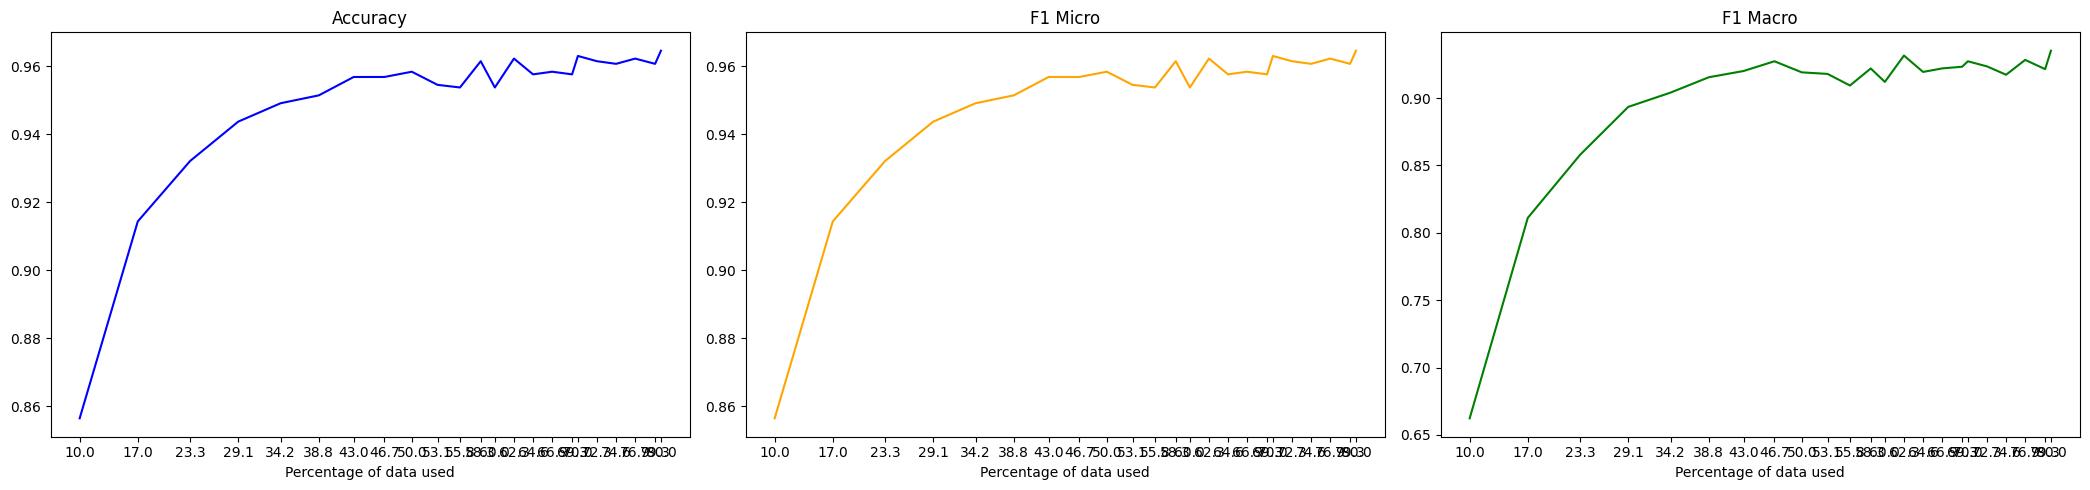

In [23]:
initial_train_size = int(0.1 * total_data)
active_learning(81, 0, 10)